In [17]:
# importing packages and modules
import numpy as np
import matplotlib as mpl
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from io_utils import *
from utils import *
from plotting_utils import *
from analysis_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm
sns.set_context("talk")

colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']
colorsStates = ['tab:orange','tab:blue','tab:green','tab:purple', 'tab:brown']
myFeatures = ['stimulus','bias','previous choice','previous correct side']
ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

In [2]:
labChosen =  ['angelakilab','churchlandlab','wittenlab']
subjectsAll = []
for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects

# missing data
if ('NYU-01' in subjectsAll):
    subjectsAll.remove('NYU-01')
if ('NYU-06' in subjectsAll):
    subjectsAll.remove('NYU-06')
if ('CSHL_007' in subjectsAll):
    subjectsAll.remove('CSHL_007')
if ('CSHL049' in subjectsAll):
    subjectsAll.remove('CSHL049')

avg_session_length = 995 # from ibl_witten_15

In [3]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 0
priorDirP = [10,1]
maxiter = 300
splitFolds = 5
D = 4 # number of features
sessStop = None # last session to use in fitting
pTanh = 5 # tanh transformation
signedStimulus = True # signed stimulus contrast
fit_init_states = False # not fitting initial latent
K_max = 5 # maximum number of states

In [4]:
# # change name of files

# for K in [1]:
#     for idx in range(0, len(subjectsAll)):
#         subject=subjectsAll[idx]
#         for fold in range(splitFolds):
#             data = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_signedStimulus={signedStimulus}.npz')
#             allP=data['allP']
#             allW=data['allW']
#             trainLl=data['trainLl']
#             testLl=data['testLl']
#             testLlSessions=data['testLlSessions']
#             testAccuracy=data['testAccuracy']
#             np.savez(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}', allP=allP, allW=allW, trainLl=trainLl, testLl=testLl, testLlSessions=testLlSessions, testAccuracy=testAccuracy)
                

In [5]:
# load test log-likelihoods for all animals (partial models)
testLlAll = np.zeros((K_max, len(subjectsAll), len(sigmaList)))
bestTestLl = np.zeros((K_max, len(subjectsAll)))
testAccuracyAll = np.zeros((K_max, len(subjectsAll), len(sigmaList)))
bestTestAccuracy = np.zeros((K_max, len(subjectsAll)))

for idx in range(0, len(subjectsAll)):
    subject = subjectsAll[idx]
    testLl = []
    testAccuracy = []
    avgTestLl = []
    old_avgTestLl = []
    avgTestAccuracy = []

    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, signedStimulus=signedStimulus, pTanh=pTanh)
    N = x.shape[0]
    presentTrain, presentTest = split_data(N, sessInd, folds=splitFolds, blocks=10, random_state=1)
    sess = len(sessInd) - 1

    for K in [1,2,3,4,5]:
        llFolds = np.empty((splitFolds), dtype=object)
        llFolds2 = np.empty((splitFolds), dtype=object)
        for fold in range(splitFolds):
            if K==1 and subject in ['IBL-T1','NYU-04','CSHL_005','CSHL_008','ibl_witten_07']:
                data = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_1-state_fold={fold}_pTanh={pTanh}_signedStimulus=True.npz')
            elif subject == 'ibl_witten_07' and K==5 and fold == 1: # missing fold
                data = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold=0_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
            else:
                data = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')

            llFolds[fold] = data['testLl']
            llFolds2[fold] = data['testAccuracy']
        avgTestLl.append(np.mean(llFolds, axis=0))
        avgTestAccuracy.append(np.mean(llFolds2, axis=0))

    for K in [1,2,3,4,5]:
        testLlAll[K-1][idx] = avgTestLl[K-1] - avgTestLl[0][0] # delta, subtracting static GLM K=1
        # testAccuracyAll[K-1][idx] = avgTestAccuracy[K-1]

    bestSigmaInd = 8  # Choosing best sigma index across animals
    for K in [1,2,3,4,5]:
        bestTestLl[K-1][idx] = avgTestLl[K-1][bestSigmaInd] - avgTestLl[0][0] # delta, subtracting static GLM K=1
        # bestTestAccuracy[K-1][idx] = avgTestAccuracy[K-1][bestSigmaInd] # - avgTestAccuracy[0][bestSigmaInd]
    

# Figure 4A

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


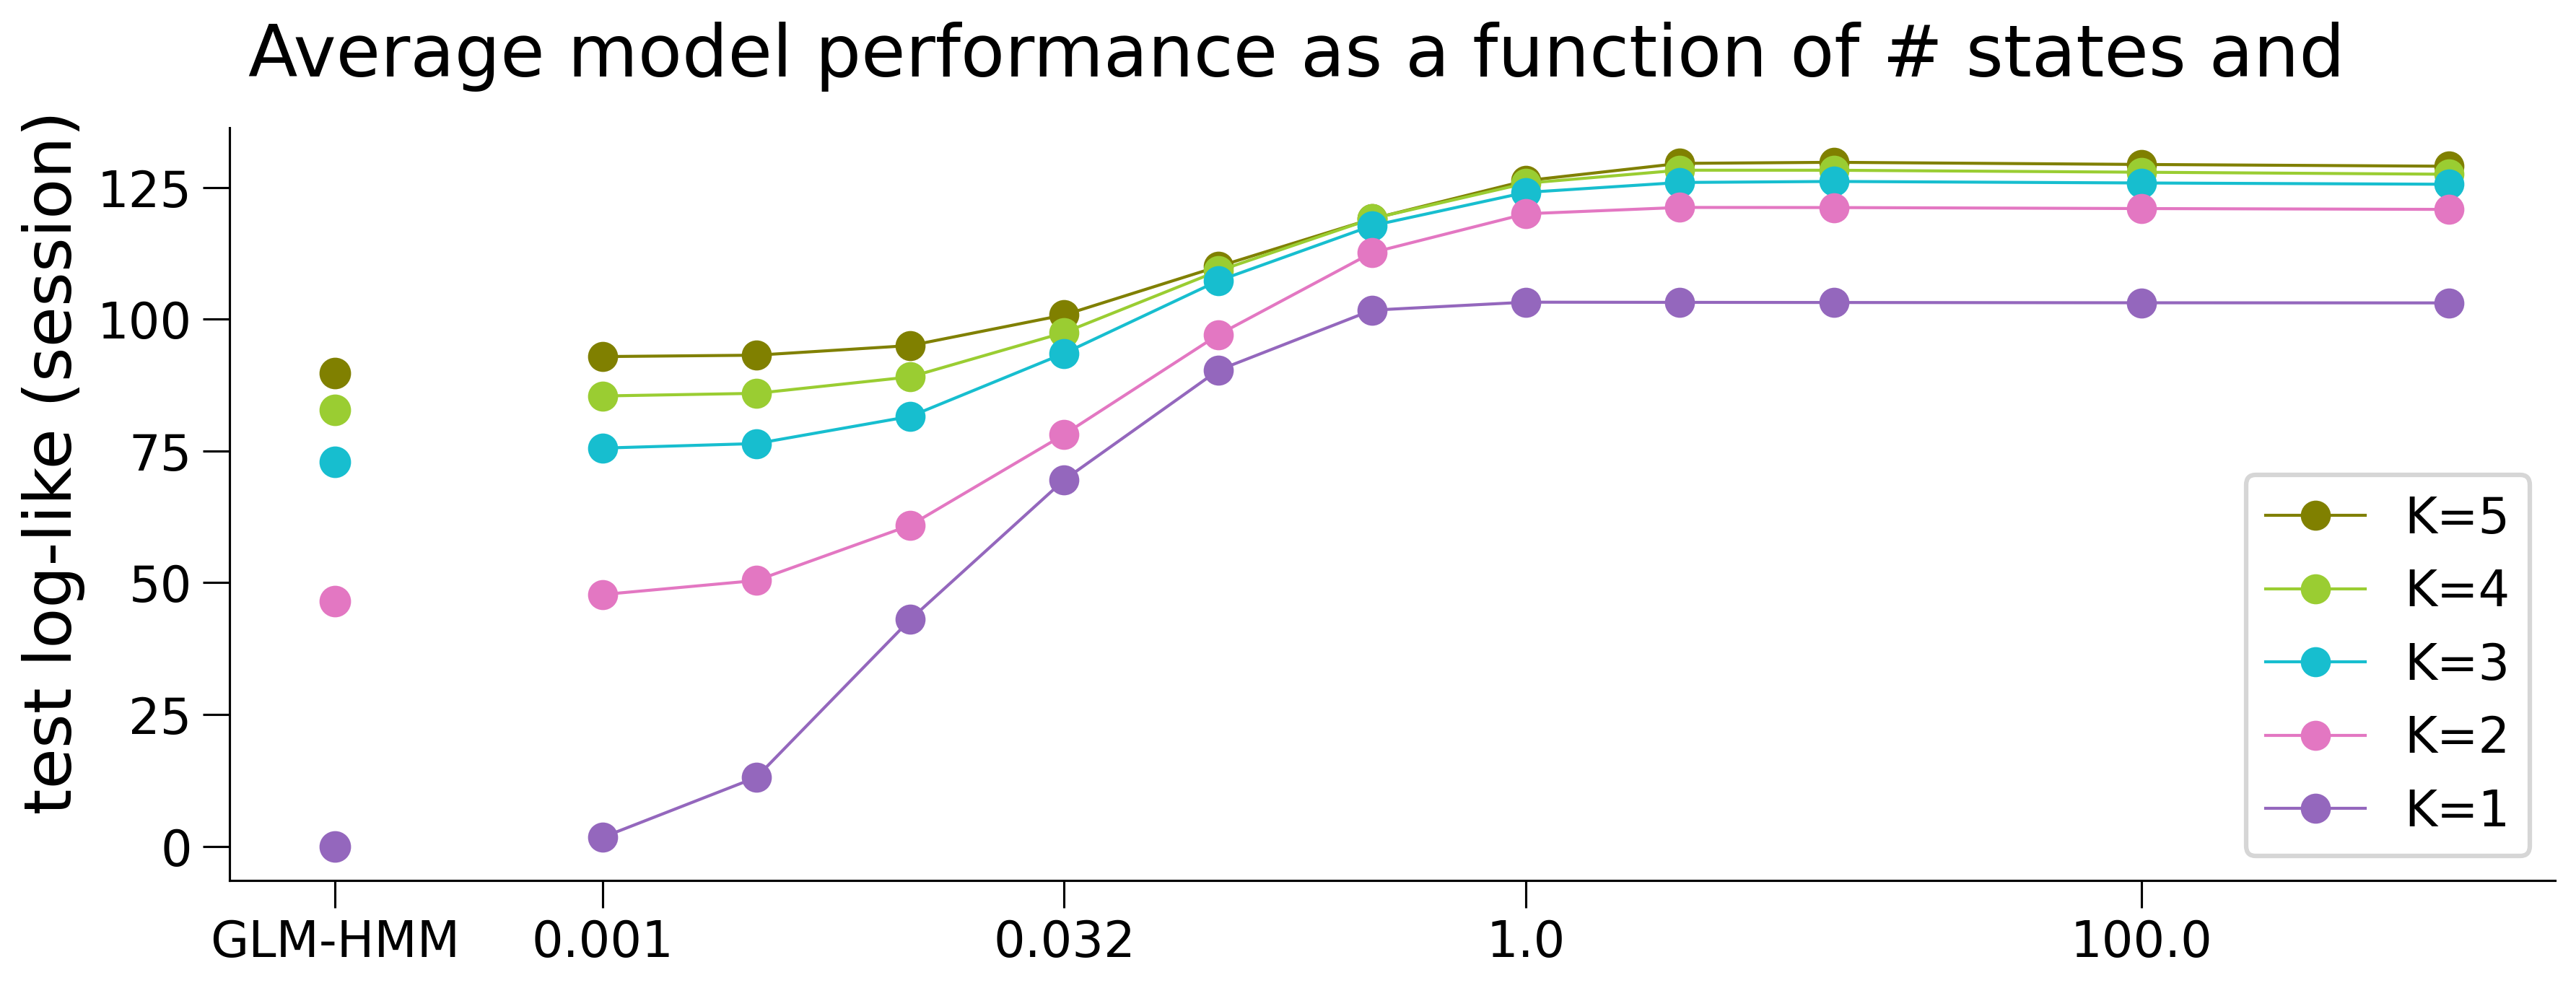

In [6]:
# Plotting delta test log-likelihood averaged across folds and animals as a function of # states and sigma
fig, axes = plt.subplots(1, figsize = (12,4.5), dpi=300)
fig.tight_layout()
for K in range(K_max,0,-1):
    # for idx in range(0, len(subjectsAll)):
    #     subject = subjectsAll[idx]
    #     plot_testLl_CV_sigma(testLlAll[K-1][idx], sigmaList=sigmaList, label=None, color=colormap[K-1], axes=axes, alpha=0.06)
    plot_testLl_CV_sigma(np.mean(testLlAll[K-1], axis=0) * avg_session_length, sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes, alpha=1, linewidth=1)
axes.set_ylabel("    test log-like (session)", size=22)
axes.set_xlabel('')
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
fig.suptitle('Average model performance as a function of # states and     ', size=24, y=1.03)
plt.savefig(f'../figures/TestLl_vs_states_sigma_all-animals.eps', format='eps', bbox_inches='tight', dpi=300)

# Figure 4B

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


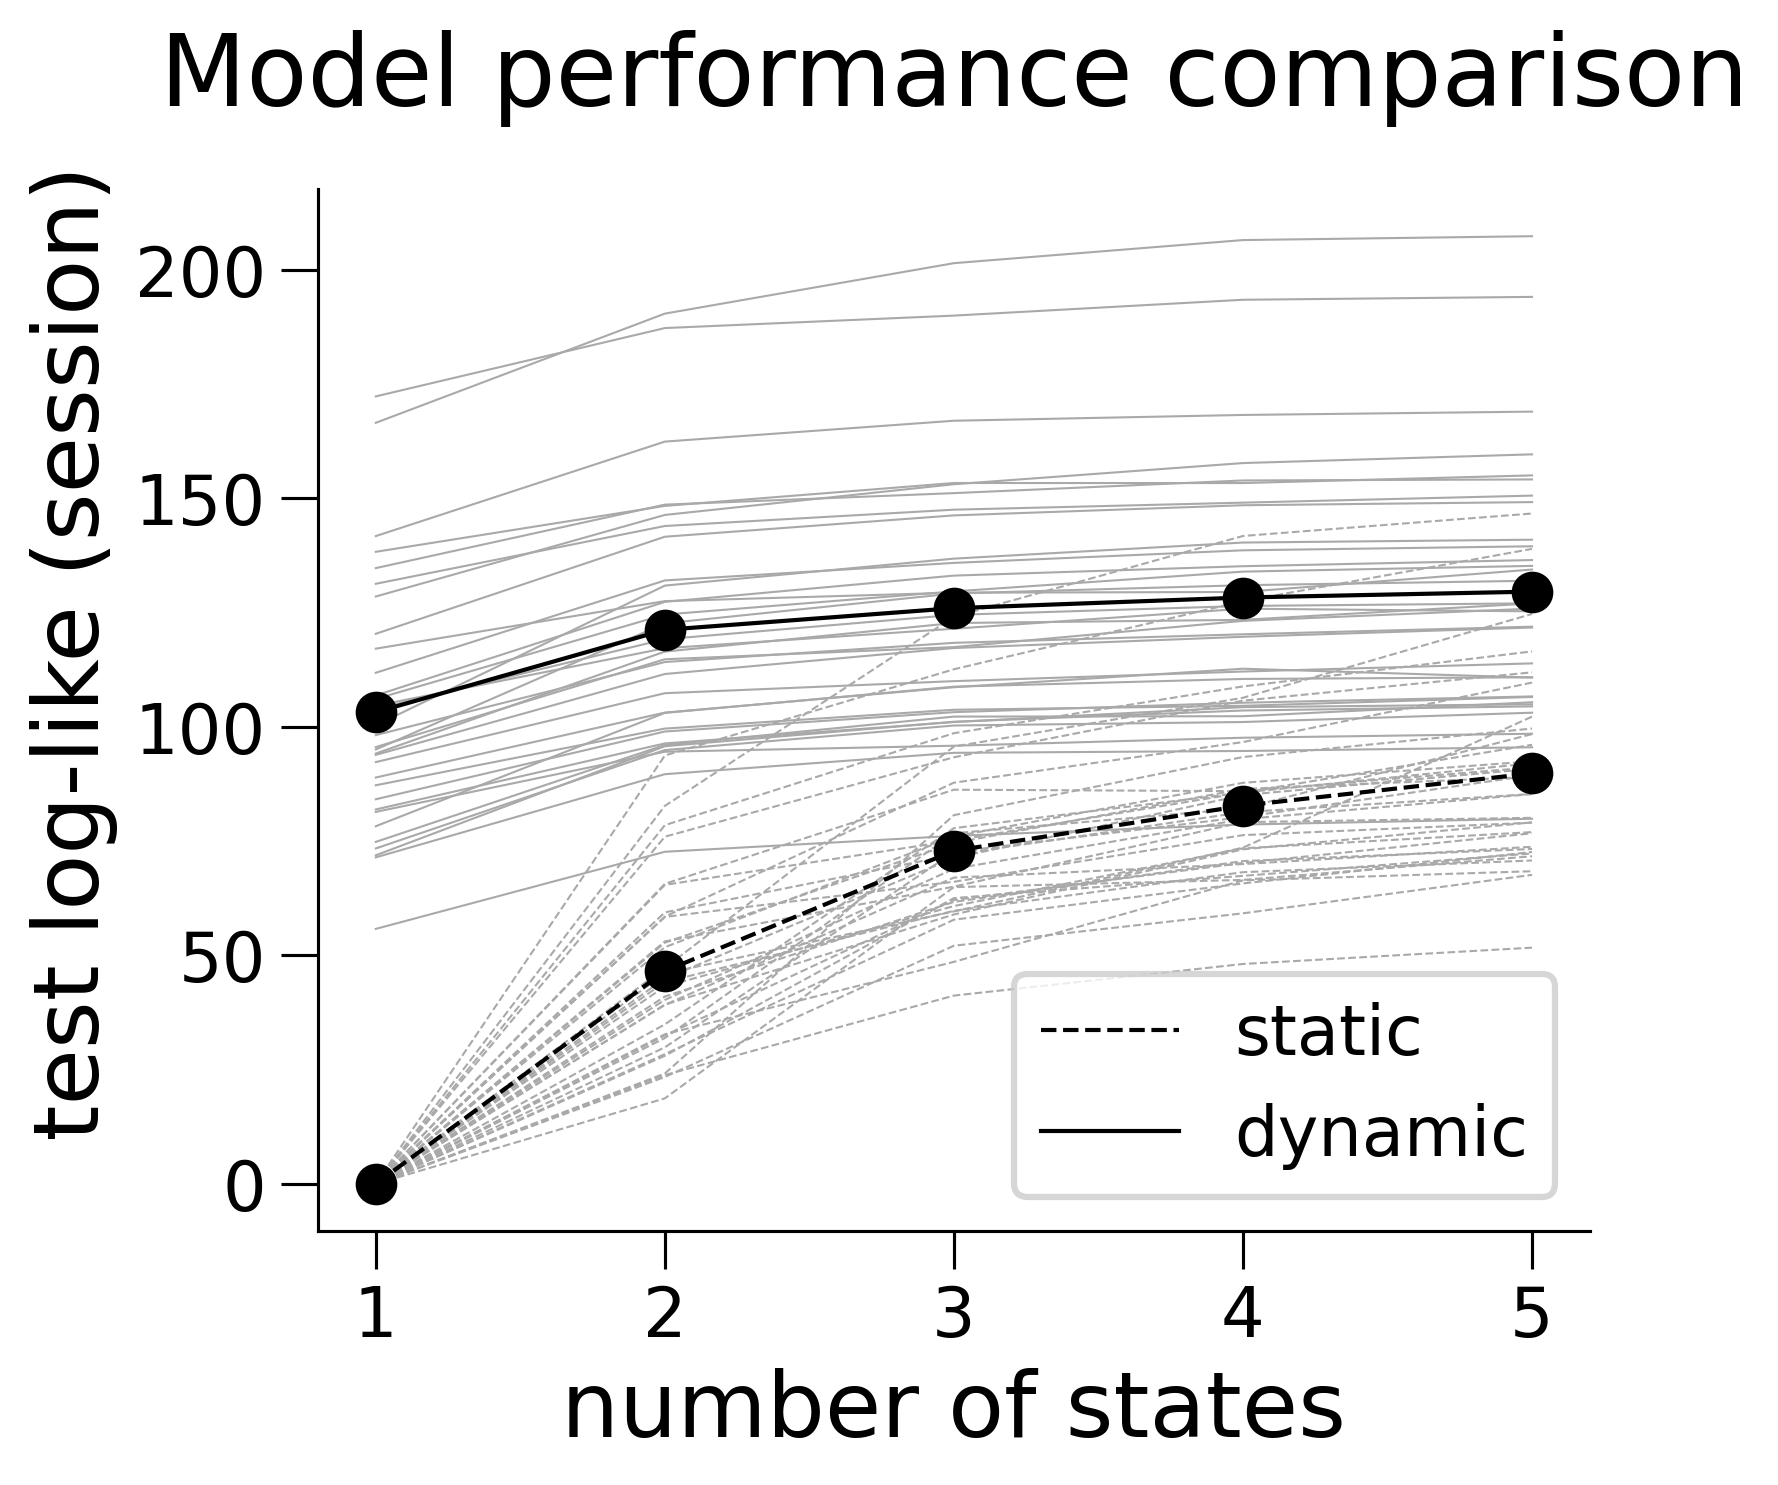

In [7]:
# Plotting delta test log-likelihood averaged across folds and animals for best static and dynamic models
fig, axes = plt.subplots(1, figsize=(5.5,4.5), dpi=300)
fig.tight_layout()
for idx in range(0, len(subjectsAll)):
    axes.plot(list(range(1,K_max+1)),bestTestLl[:,idx]* avg_session_length, color='darkgray', linewidth=0.5, zorder=0)
    axes.plot(list(range(1,K_max+1)), testLlAll[:,idx,0] * avg_session_length, color='darkgray',alpha=1, linewidth=0.5, linestyle='dashed', zorder=0)
axes.set_xticks(list(range(1,K_max+1)))
axes.plot(list(range(1,K_max+1)), np.mean(testLlAll, axis=1)[:,0] * avg_session_length, color='black',alpha=1, label='static', linewidth=1, linestyle='dashed', zorder=1)
axes.plot(list(range(1,K_max+1)), np.mean(bestTestLl, axis=1)[:] * avg_session_length, color='black',alpha=1, label='dynamic', linewidth=1, zorder=1)
axes.scatter(list(range(1,K_max+1)), np.mean(testLlAll, axis=1)[:,0] * avg_session_length, color='black',alpha=1, linewidth=1)
axes.scatter(list(range(1,K_max+1)), np.mean(bestTestLl, axis=1)[:] * avg_session_length, color='black',alpha=1, linewidth=1)
axes.set_xlabel('number of states', size=22)
axes.set_ylabel('    test log-like (session)', size=22)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.set_title(f'Model performance comparison', size=24, pad=20)
axes.legend()
plt.savefig(f'../figures/TestLl_dyanmics_static_vs_states_sigma=3.2_all-animals.eps', format='eps', bbox_inches='tight', dpi=300)

In [8]:
# # CHECK ACCURACY AS WELL

# # Plotting one plot with all animals and their mean
# fig, axes = plt.subplots(1, figsize = (12,4.5), dpi=400)
# # fig, axes = plt.subplots(1, figsize = (12,5.5), dpi=400)
# fig.tight_layout()
# # axes.set_title('averaged across all animals')
# for K in range(K_max,0,-1):
#     # for idx in range(0, len(subjectsAll)):
#     #     subject = subjectsAll[idx]
#     #     plot_testLl_CV_sigma(testLlAll[K-1][idx], sigmaList=sigmaList, label=None, color=colormap[K-1], axes=axes, alpha=0.06)

#     plot_testLl_CV_sigma(np.mean(testAccuracyAll[K-1], axis=0) , sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes, alpha=1)
#     # plot_testLl_CV_sigma(np.mean(old_testLlAll[K-1], axis=0) * avg_session_length, sigmaList=sigmaList, label=f'K={K}', color='black', axes=axes, alpha=1, linestyle='--')
# axes.set_ylabel("    test log-like (session)", size=22)
# axes.set_xlabel('')
# axes.spines[['right', 'top']].set_visible(False)
# fig.suptitle('Average model performance as a function of # states and     ', size=24)
# # plt.savefig(f'../figures/TestLl_vs_states_sigma_all-animals.png', bbox_inches='tight', dpi=400)



In [9]:
# load fitted parameters from best partial and dynamic 3-state models
K = 3 # number of states to proceed with analysis
bestAlphaInd = 2 # verified
bestSigmaInd = 8 # verified
allP_best_partial = np.zeros((len(subjectsAll), K, K))   
allW_best_partial = np.empty((len(subjectsAll)), dtype=object)
allP_best_dynamic = np.empty((len(subjectsAll)), dtype=object)
allW_best_dynamic = np.empty((len(subjectsAll)), dtype=object)

for idx in range(0, len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, signedStimulus=signedStimulus, pTanh=pTanh)
    N = x.shape[0]

    # parameters for best partial model
    P_fold = np.empty((splitFolds), dtype=object)
    W_fold = np.empty((splitFolds), dtype=object)
    for fold in range(splitFolds):
        data_partial = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        P_fold[fold] = data_partial['allP']
        W_fold[fold] = data_partial['allW']
    allP_best_partial[idx] = np.mean(P_fold, axis=0)[bestSigmaInd,0] # for partial model, transition matrix is constant
    allW_best_partial[idx], _ = reshape_parameters_session_to_trials(np.mean(W_fold, axis=0)[bestSigmaInd], np.mean(P_fold, axis=0)[bestSigmaInd], sessInd)

    # parameters for best dynamic model
    P_fold = np.empty((splitFolds), dtype=object)
    W_fold = np.empty((splitFolds), dtype=object)
    for fold in range(splitFolds):
        data_dynamic = np.load(f'../data_IBL/{subject}/{subject}_dynamicGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        P_fold[fold] = data_dynamic['allP']
        W_fold[fold] = data_dynamic['allW']
    allW_best_dynamic[idx], allP_best_dynamic[idx] = reshape_parameters_session_to_trials(np.mean(W_fold, axis=0)[bestAlphaInd], np.mean(P_fold, axis=0)[bestAlphaInd], sessInd)


# Figure 4C

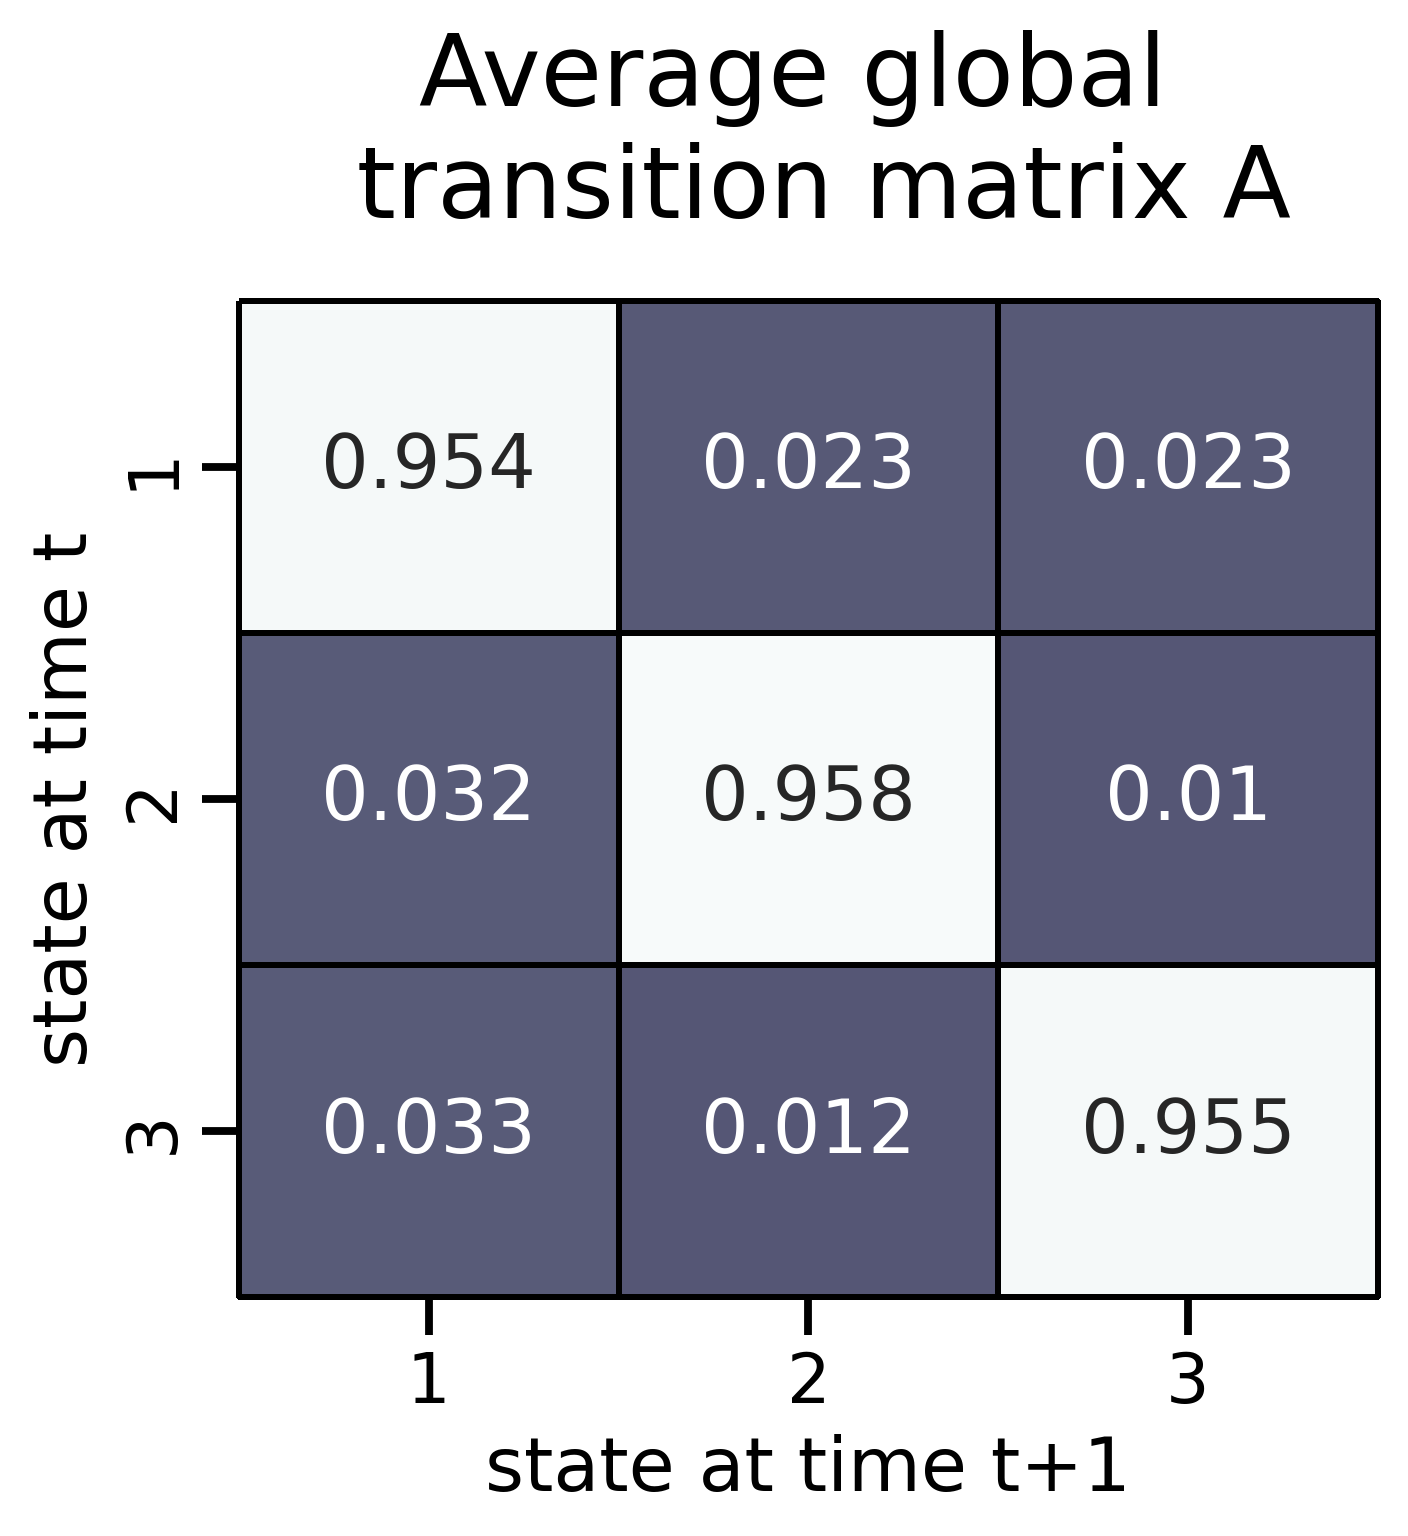

In [10]:
# plotting inferred static transition matrix
plt.figure(figsize=(4.9, 4.4), dpi=300)
s = sns.heatmap(np.round(np.mean(allP_best_partial, axis=0),3),annot=True, vmin=-0.6, vmax=1,cmap='bone', fmt='g', linewidths=1, linecolor='black',clip_on=False, cbar=False)
s.set(xlabel='state at time t+1', ylabel='state at time t', title=f'', xticklabels=range(1,K+1), yticklabels=range(1,K+1))
plt.title('Average global \n transition matrix A', size=24, pad=20)
plt.savefig(f'../figures/AverageP_2-state_sigma=1_allAnimals.eps', format='eps', bbox_inches='tight', dpi=300)
      

In [11]:
# compute observation probabilities (probability of a choice given state and task covariates)
allPhi = np.empty((len(subjectsAll)), dtype=object) 
for idx in range(0,len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, signedStimulus=signedStimulus, pTanh=pTanh)
    N = sessInd[-1]
    dGLMHMM = dynamic_glmhmm.dynamic_GLMHMM(N,K,D,2)
    allPhi[idx] = dGLMHMM.observation_probability(x, allW_best_dynamic[idx])

# Figure 4D

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


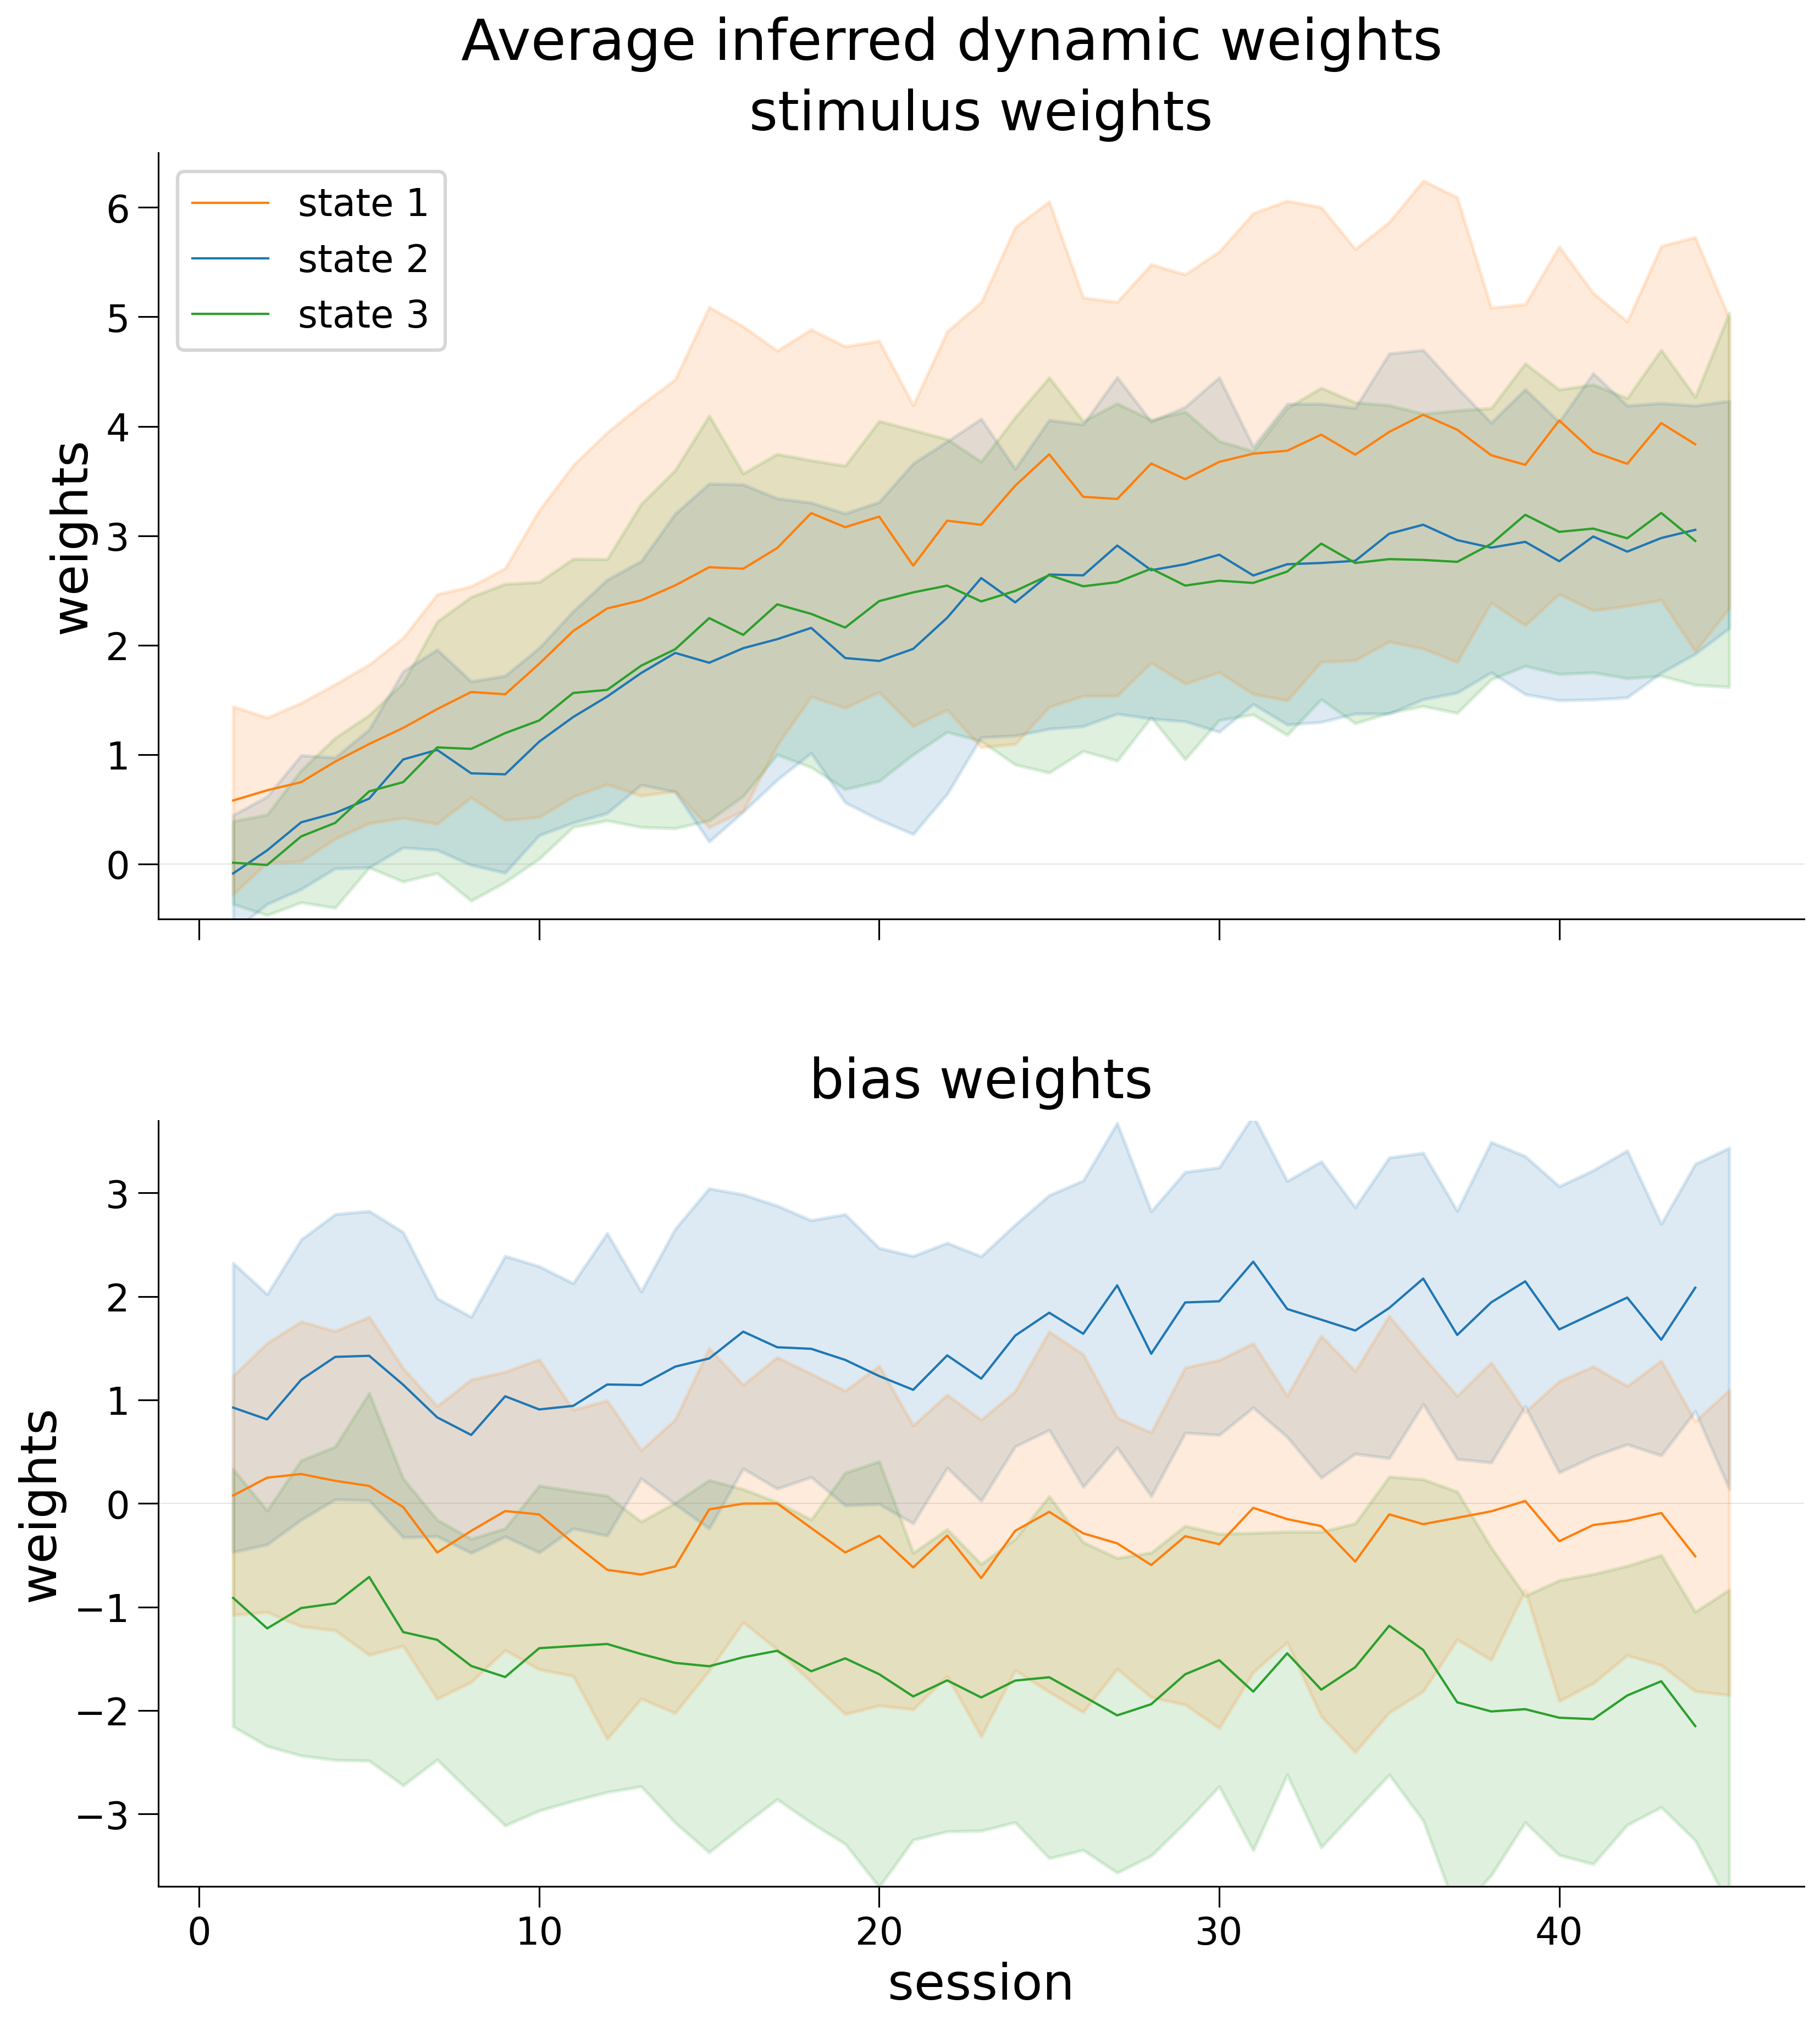

In [30]:
# Plotting inferred weights averaged across all animals - first 45 sessions
maxSess = 45
reorderFeatures = [1,0,2,3] 
arrW = np.ma.empty((maxSess, K, D, 2, len(subjectsAll)))
arrW.mask = True

fig, axes = plt.subplots(2, 1,figsize=(12.7,13), sharex=True, dpi=300)
fig.tight_layout(pad=4)
yLim=[[-0.5,6.5],[-3.7,3.7],[-3.7,3.7],[-3.7,3.7]]

avgP = []
avgW = []
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
    avgW.append(allW_best_dynamic[idx][sessInd[:-1]]) 
    stop = min(avgW[idx].shape[0], maxSess)
    arrW[:stop, :K, :2, :2, idx] = avgW[idx][:stop, :, :2]
for k in np.arange(K-1,-1,-1):
    for d in range(0,2):
        axes[d].fill_between(range(1,maxSess+1), arrW[:,k,reorderFeatures[d],1,:].mean(axis=1) - arrW[:,k,reorderFeatures[d],1,:].std(axis=1), arrW[:,k,reorderFeatures[d],1,:].mean(axis=1) + arrW[:,k,reorderFeatures[d],1,:].std(axis=1), alpha=0.15, color=colorsStates[k])
plotting_weights_per_feature(arrW.mean(axis=4)[:,:,reorderFeatures[:2],:], [x for x in range (0, maxSess)], axes, yLim=yLim, colors=colorsStates, labels=['stimulus','bias'], linewidth=1, linestyle='-', alpha=1, legend=True, sortedStateInd=None)
for d in range(0,D-2):
    if (d!=0):
        axes[d].get_legend().remove()
        axes[0].legend(loc = 'upper left')
    axes[d].set_ylim(yLim[d])
    axes[d].set_ylabel(f'weights', size=22)
    axes[d].set_title(f'{myFeatures[d]} weights', size=24, pad=10)
    axes[d].spines[['right', 'top']].set_visible(False)
    axes[d].spines[['left', 'bottom']].set_linewidth(0.75)
    axes[d].xaxis.set_tick_params(width=0.75)
    axes[d].yaxis.set_tick_params(width=0.75)
fig.suptitle('Average inferred dynamic weights', size=25)
axes[-1].set_xlabel('session', size=22)
plt.savefig(f'../figures/weights_sigma=3.1_allAnimals.eps', format='eps', bbox_inches='tight', dpi=300)

# Figure 4F

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


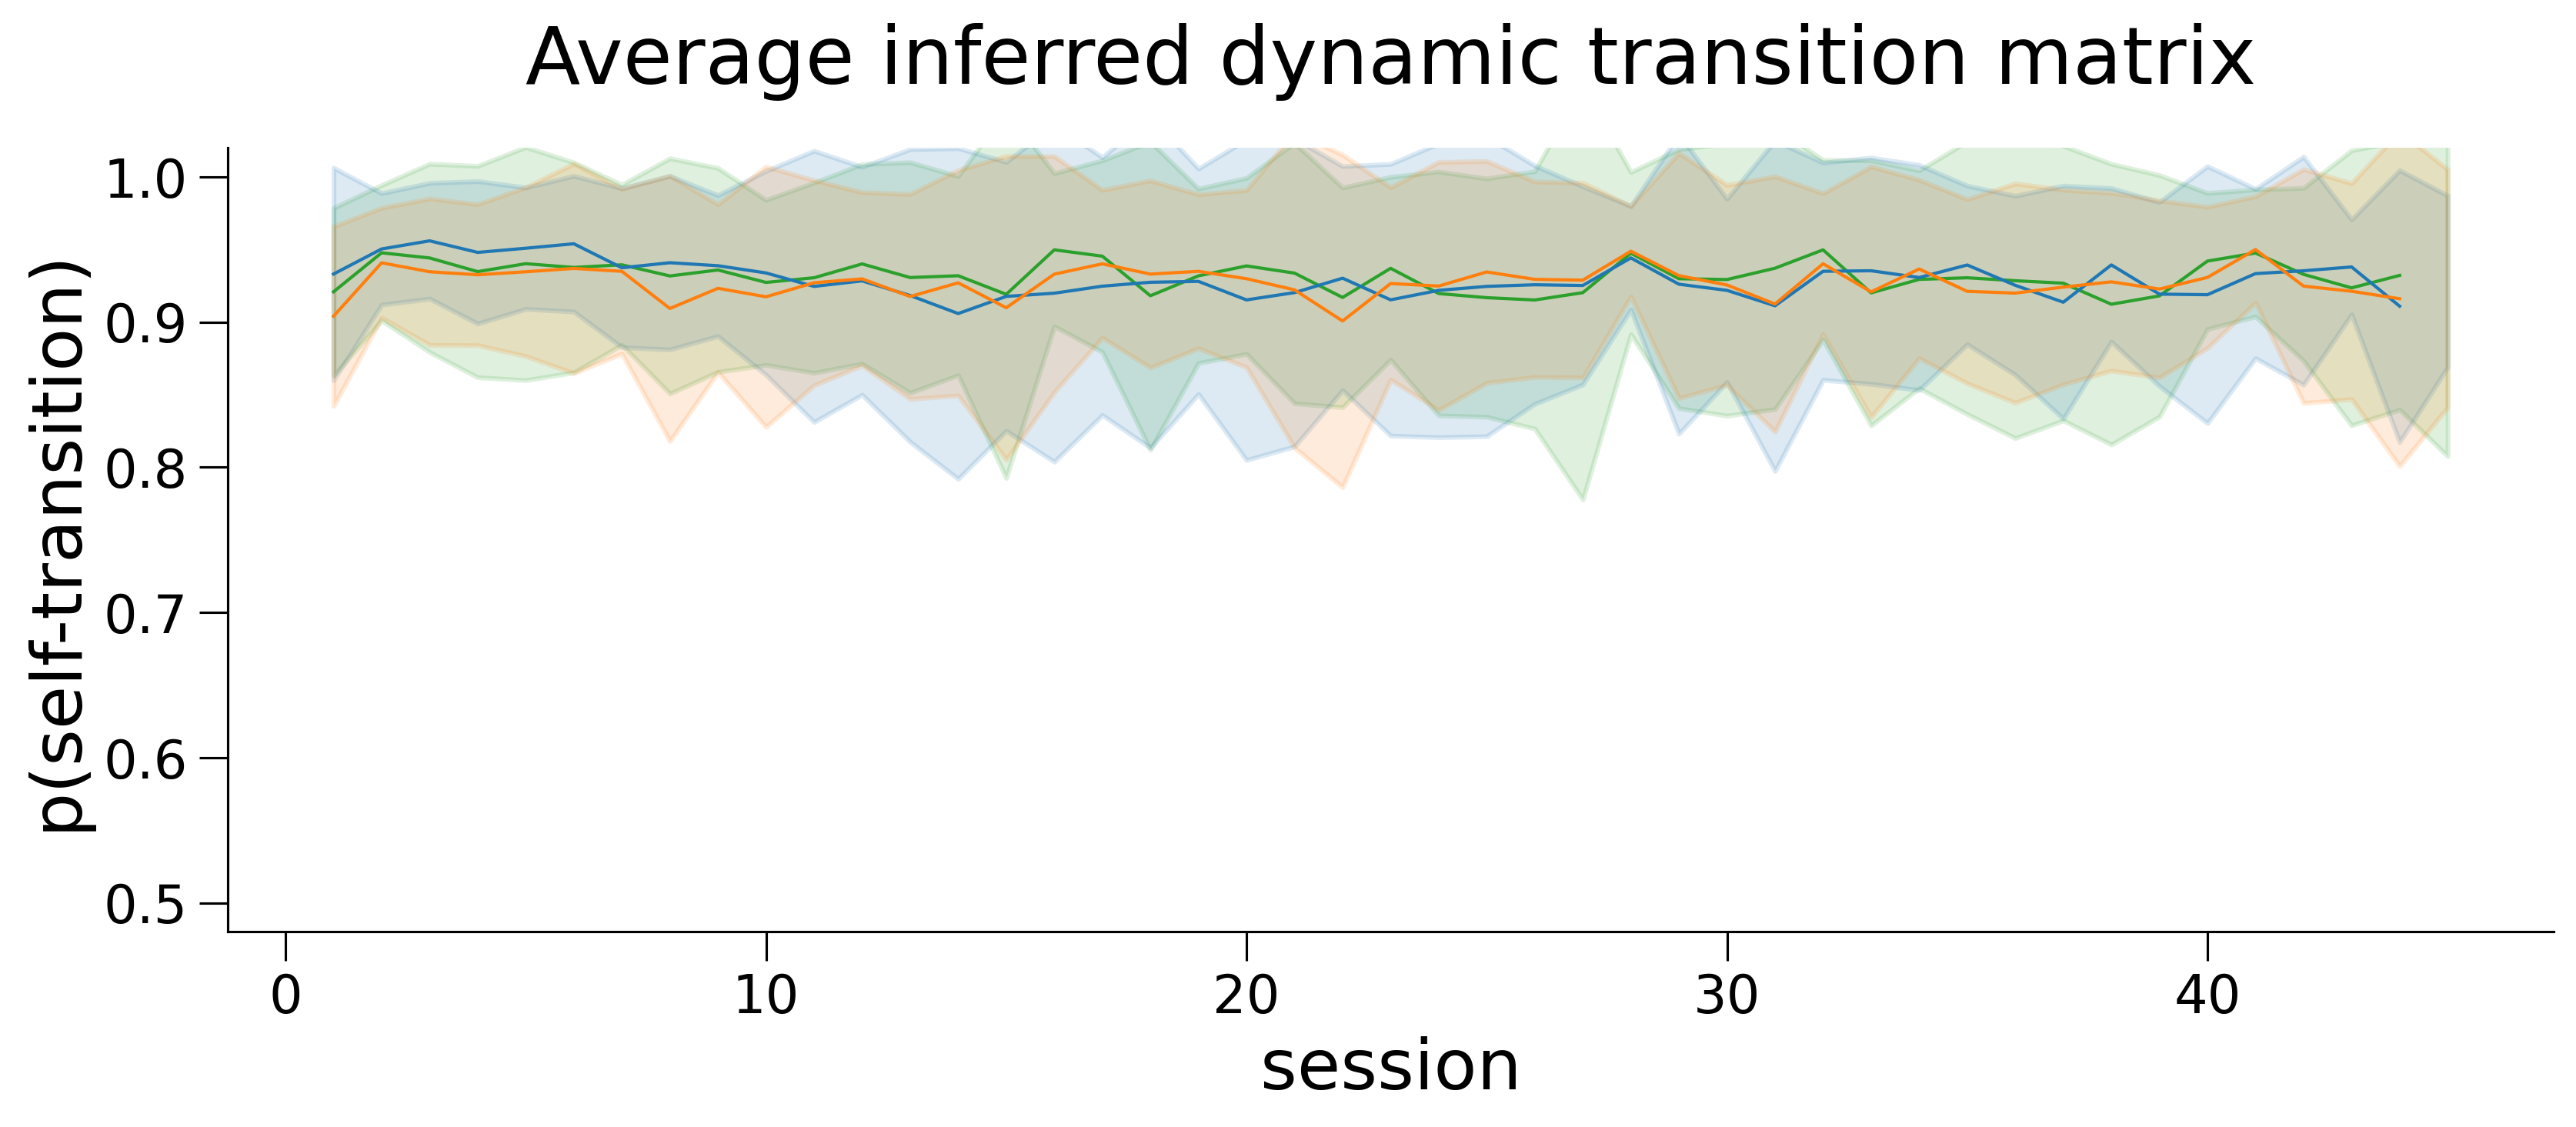

In [33]:
# Plotting transition matrix averaged across all animals - first 45 sessions
fig, axes = plt.subplots(1, figsize = (13,4.5), dpi=300) # for poster
arrP = np.ma.empty((maxSess, K, K, len(subjectsAll)))
arrP.mask = True
avgP = []
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
    avgP.append(allP_best_dynamic[idx][sessInd[:-1]])
    stop = min(avgW[idx].shape[0], maxSess)
    arrP[:stop, :K, :K, idx] = avgP[idx][:stop]
    sessInd = range(0,stop)
    sess = len(sessInd)-1
for k in np.arange(K-1,-1,-1):
    axes.fill_between(range(1,maxSess+1), arrP.mean(axis=3)[:,k,k] - arrP.std(axis=3)[:,k,k], arrP.mean(axis=3)[:,k,k] + arrP.std(axis=3)[:,k,k], alpha=0.15, color=colorsStates[k])
plotting_self_transition_probabilities(arrP.mean(axis=3), range(0,maxSess), axes, title='', linestyle='-', linewidth=1, sortedStateInd=None, colorsStates=colorsStates)
axes.set_ylabel("p(self-transition)", size=22)
axes.set_xlabel('session', size=22)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.set_title('Average inferred dynamic transition matrix', size=25, pad=20)
axes.set_ylim(0.48,1.02)
plt.savefig(f'../figures/Self-transition_probabilties-alpha=2_allAnimals.eps', format='eps', bbox_inches='tight', dpi=300)
          

In [34]:
# Computing posterior probability of latents across animals 
allGamma = np.empty((len(subjectsAll)), dtype=object)
truepi = np.ones((K))
for idx in range(0,len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
    N = sessInd[-1]
    presentAll = np.ones((N))
    dGLM_HMM = dynamic_glmhmm.dynamic_GLMHMM(N,K,D,2)
    allGamma[idx] = dGLM_HMM.get_posterior_latent(allP_best_dynamic[idx], truepi, allW_best_dynamic[idx], x, y, presentAll, sessInd, sortedStateInd=None)


In [45]:
# Computing per-state occupancy and accuracy
allStateCount = np.empty((len(subjectsAll)), dtype=object)
allStateSoft = np.empty((len(subjectsAll)), dtype=object)
allStateCorrect = np.empty((len(subjectsAll)), dtype=object)
allOverallCorrect = np.empty((len(subjectsAll)), dtype=object)
allStateCorrectSeparate = np.empty((len(subjectsAll), 2), dtype=object) # separate for easy trials and hard trials
allOverallCorrectSeparate = np.empty((len(subjectsAll), 2), dtype=object) # separate for easy trials and hard trials

fig, axes = plt.subplots(1, figsize = (14,5))#, dpi=400)
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)

    # Plotting task occupancy of each state across sessions
    axes.set_title(subject)
    allStateCount[idx] = plot_state_occupancy_sessions(allGamma[idx], sessInd, axes, colors=colorsStates)
    allStateSoft[idx] = np.zeros((len(sessInd)-1, 3))
    for sess in range(0,len(sessInd)-1):
        allStateSoft[idx][sess] = np.mean(allGamma[idx][sessInd[sess]:sessInd[sess+1],:], axis=0)
    axes.set_ylim(-1,101)

    # plotting task accuracy in each state across sessions
    axes.set_title(subject)
    _, _, allOverallCorrect[idx], allStateCorrect[idx] = accuracy_states_sessions(allGamma[idx], allPhi[idx], y, correctSide, sessInd)
    axes.set_ylim(40,100)

    # calculating performance on easy trials for each state
    data = dfAll[dfAll['subject']==subject]
    dateToKeep = np.unique(data['date'])   
    dataTemp = pd.DataFrame(data.loc[data['date'].isin(list(dateToKeep))])
    contrastLeft=np.array(dataTemp['contrastLeft'])
    contrastRight=np.array(dataTemp['contrastRight'])
    easyTrials = (contrastLeft > 0.45).astype(int) | (contrastRight > 0.45).astype(int)
    correctSidee = np.array(dataTemp['correctSide'])

    # computing per state accuracy for easy trials
    N = y.shape[0]
    p_correct_states = np.ma.empty((N, K, 2)) # separate for easy and hard trials (last column) # 1 = easy, 0 = hard
    p_correct = np.ma.empty((N, 2))
    p_correct_states_sessions = np.ma.empty((len(sessInd)-1, K, 2))
    p_correct_sessions = np.ma.empty((len(sessInd)-1, 2))

    p_correct_states.mask = True
    p_correct.mask = True
    p_correct_states_sessions.mask = True
    p_correct_sessions.mask = True
    for session in range(0, len(sessInd)-1):
        for t in range(sessInd[session],sessInd[session+1]):
            for k in range(0,K):
                p_correct_states[t, k, easyTrials[t]] = allPhi[idx][t, k, correctSide[t]]
            if (np.ma.is_masked(p_correct_states[t, 0, 0]) == False): # means trial happened (not masked)
                p_correct[t, 0] = p_correct_states[t, :, 0] @ allGamma[idx][t] # hard trials
            if (np.ma.is_masked(p_correct_states[t, 0, 1]) == False): # means trial happened (not masked)
                p_correct[t, 1] = p_correct_states[t, :, 1] @ allGamma[idx][t] # easy trials
    
        p_correct_states_sessions[session] = np.nanmean(p_correct_states[sessInd[session]:sessInd[session+1]], axis=0) 
        p_correct_sessions[session] = np.nanmean(p_correct[sessInd[session]:sessInd[session+1]], axis=0)

    allStateCorrectSeparate[idx, 0] = 100 * p_correct_states_sessions[:, :, 0] # hard
    allStateCorrectSeparate[idx, 1] = 100 * p_correct_states_sessions[:, :, 1] # easy
    allOverallCorrectSeparate[idx, 0] = 100 * p_correct_sessions[:, 0]
    allOverallCorrectSeparate[idx, 1] = 100 * p_correct_sessions[:, 1]

plt.close()



# Figure 4E

Text(0.5, 1.0, 'Average per-state accuracy')

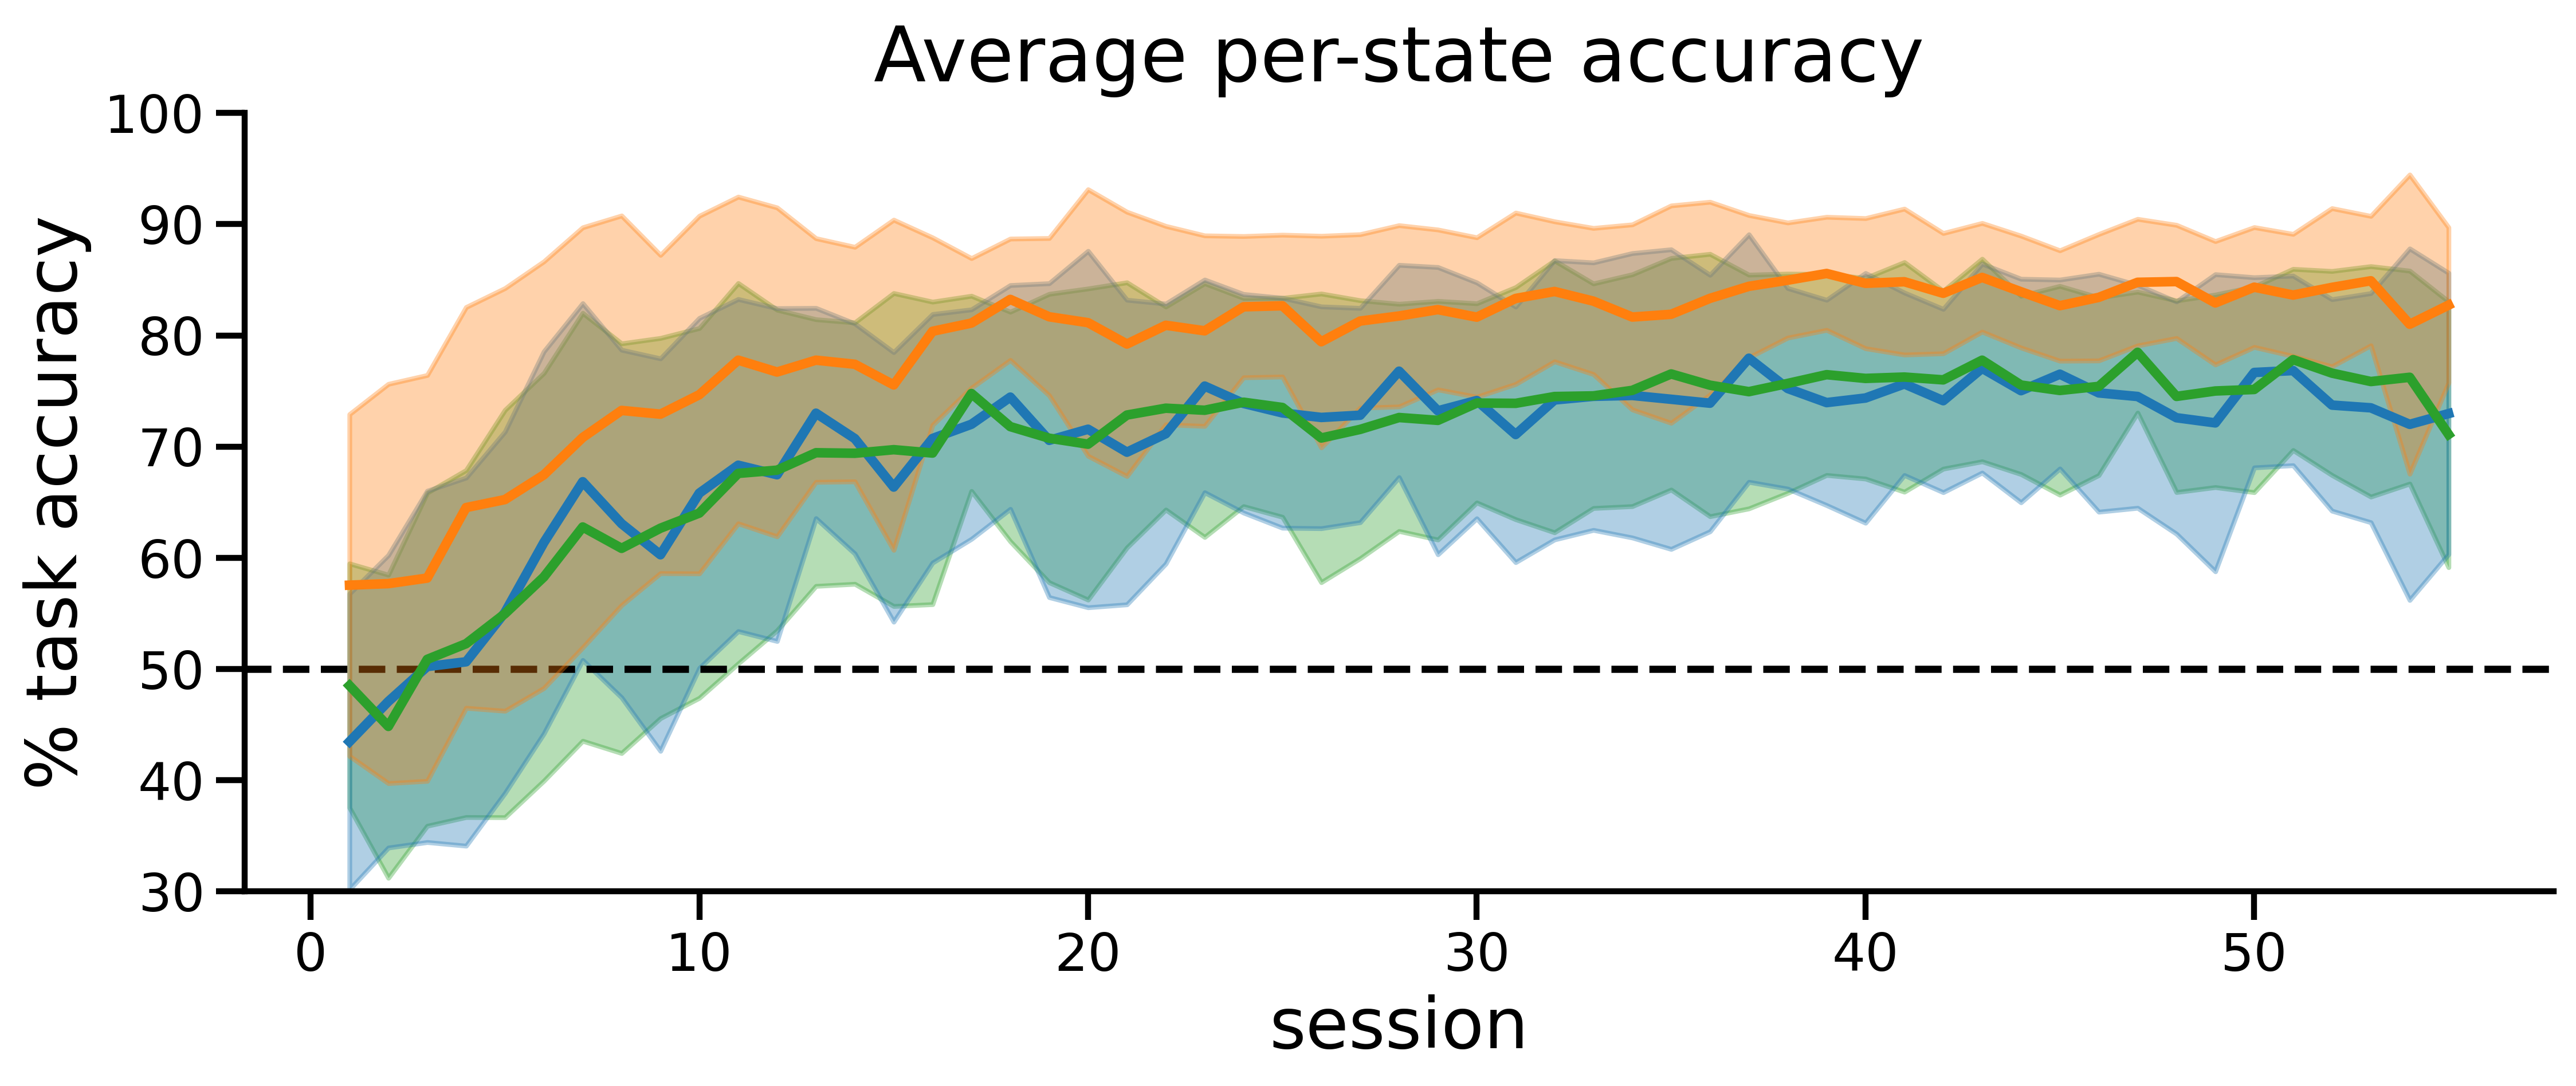

In [46]:
fig, axes = plt.subplots(1, figsize = (13,4.5), dpi=400)

arrStateCorrect = np.ma.empty((maxSess,K,len(subjectsAll)))
arrStateCorrect.mask = True

arrOverallCorrect = np.ma.empty((maxSess,len(subjectsAll)))
arrOverallCorrect.mask = True

arrEmpiricalCorrect = np.ma.empty((maxSess,len(subjectsAll)))
arrEmpiricalCorrect.mask = True

axes.axhline(50,color='black',linestyle='dashed')
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)

    # empirical accuracy
    empiricalAccuracy = np.zeros((len(sessInd)-1))
    correct = correctSide == y
    for s in range(0,len(sessInd)-1):
        empiricalAccuracy[s] = np.mean(correct[sessInd[s]:sessInd[s+1]]) * 100

    stop = min(len(sessInd)-1, maxSess)
    arrStateCorrect[:stop, :K, idx] = allStateCorrect[idx][:stop]
    arrOverallCorrect[:stop, idx] = allOverallCorrect[idx][:stop]
    arrEmpiricalCorrect[:stop, idx] = empiricalAccuracy[:stop]
    
for k in range(0,K):
    axes.plot(range(1,maxSess+1), np.nanmean(arrStateCorrect[:,k,:], axis=1), color=colorsStates[k], linewidth=3, label=f'state {k+1}', zorder=3)
    axes.fill_between(range(1,maxSess+1), np.nanmean(arrStateCorrect[:,k,:], axis=1)-np.nanstd(arrStateCorrect[:,k,:], axis=1), np.nanmean(arrStateCorrect[:,k,:], axis=1)+np.nanstd(arrStateCorrect[:,k,:], axis=1), alpha=0.35, zorder=2-k, color=colorsStates[k])
axes.set_ylabel('% task accuracy', size=22)
axes.set_xlabel('session', size=22)
axes.set_ylim(30,100)
axes.legend(loc='upper left')
axes.spines[['right', 'top']].set_visible(False)
axes.get_legend().remove()
axes.set_title('Average per-state accuracy', size=24, pad=10)
# plt.savefig(f'../figures/Accuracy_states_allAnimals', bbox_inches='tight', dpi=400)

# Figure 4G

Text(0.5, 1.0, 'Average per-state occupancy')

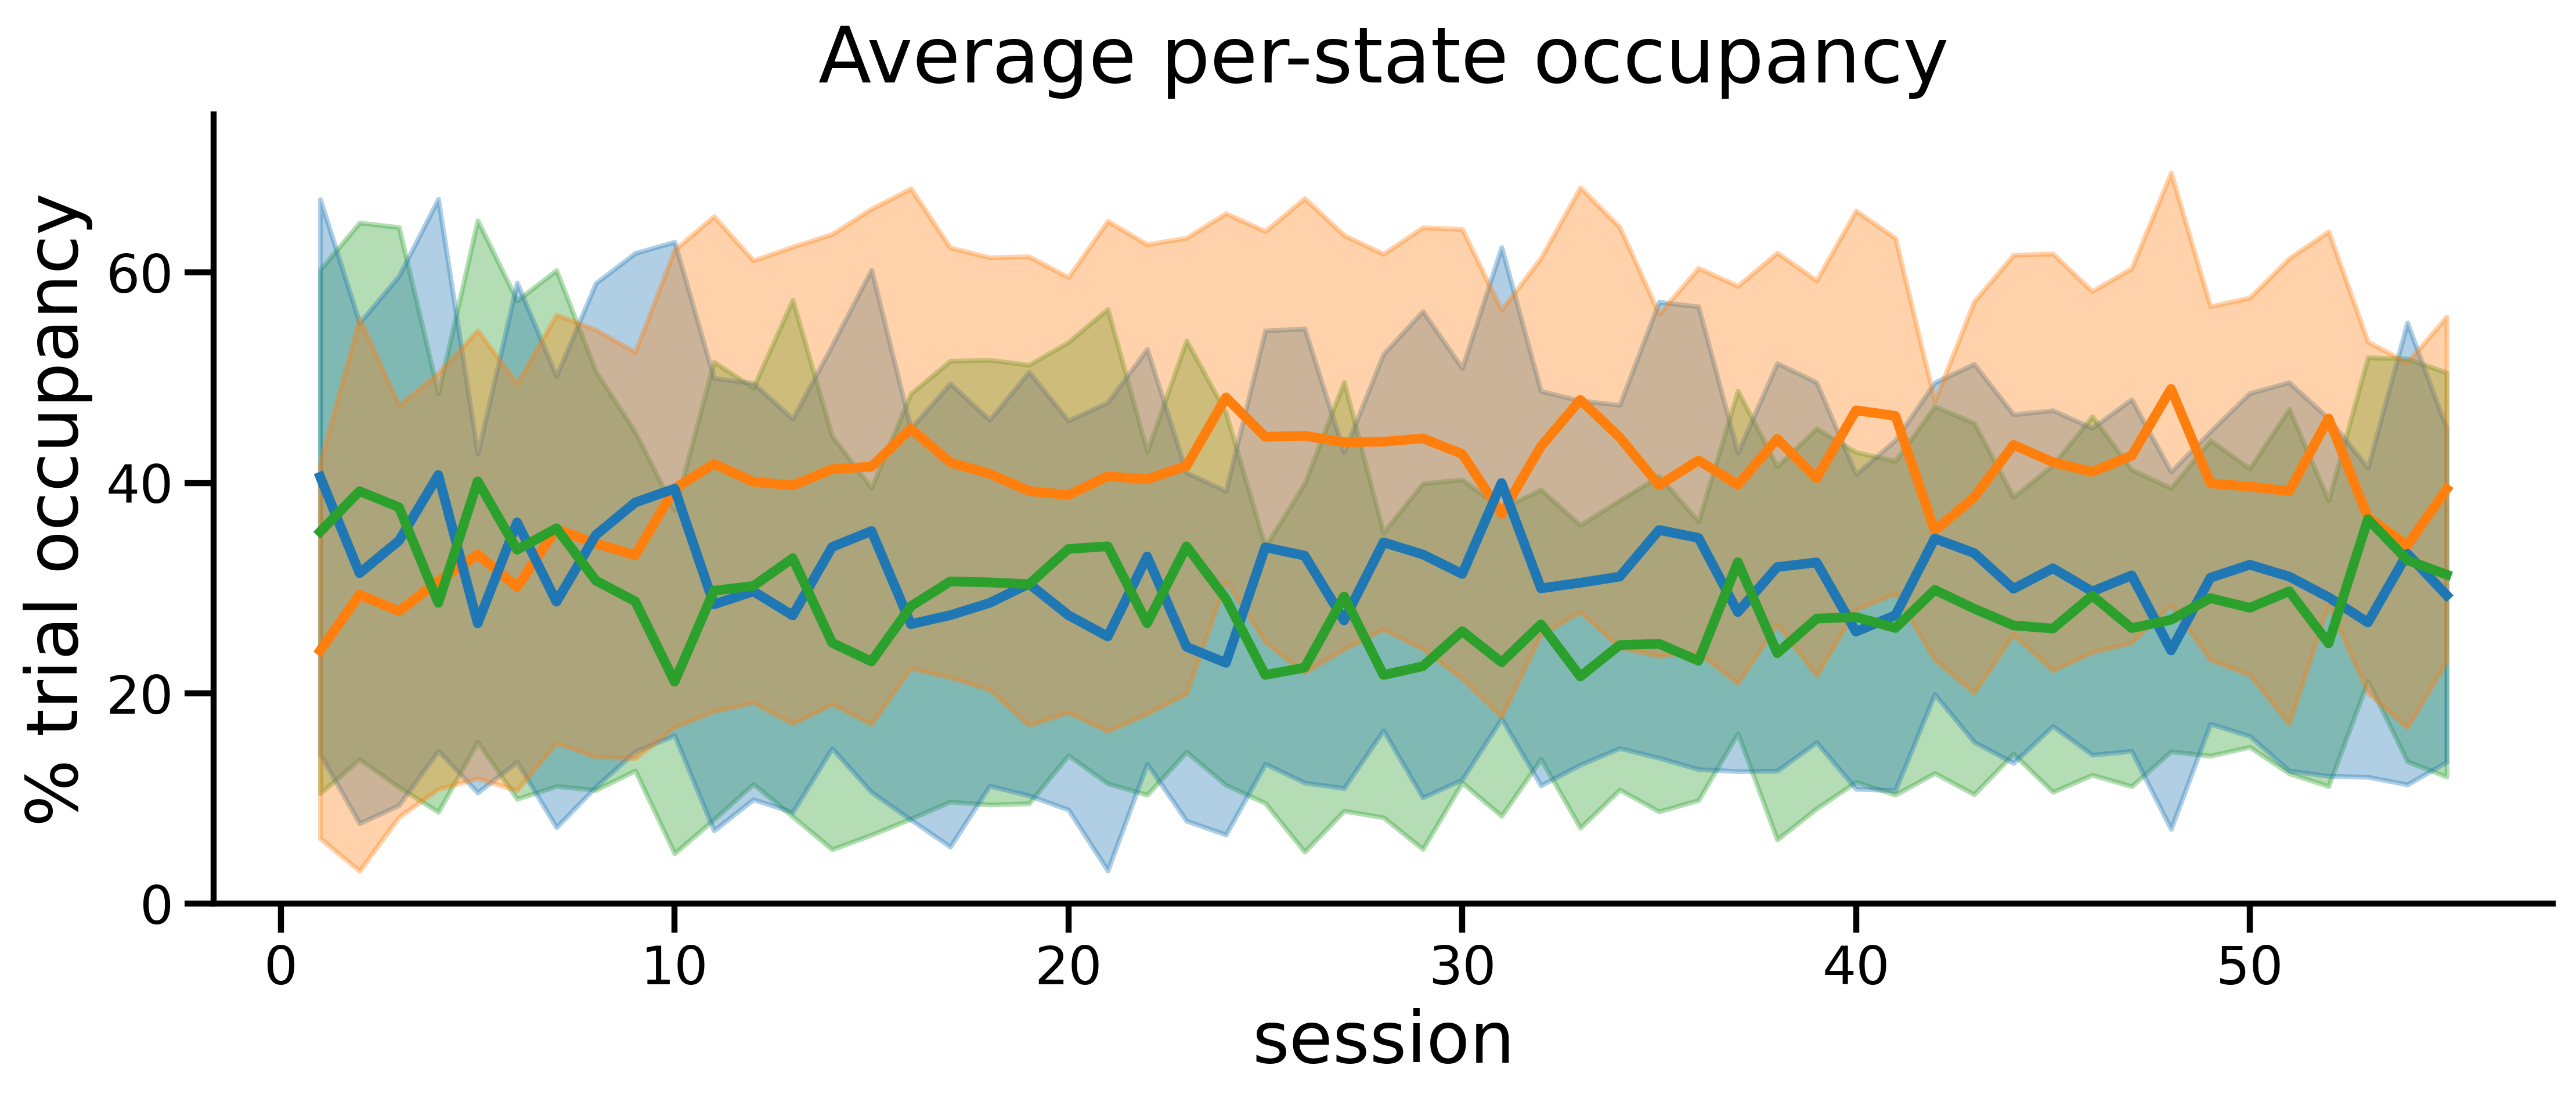

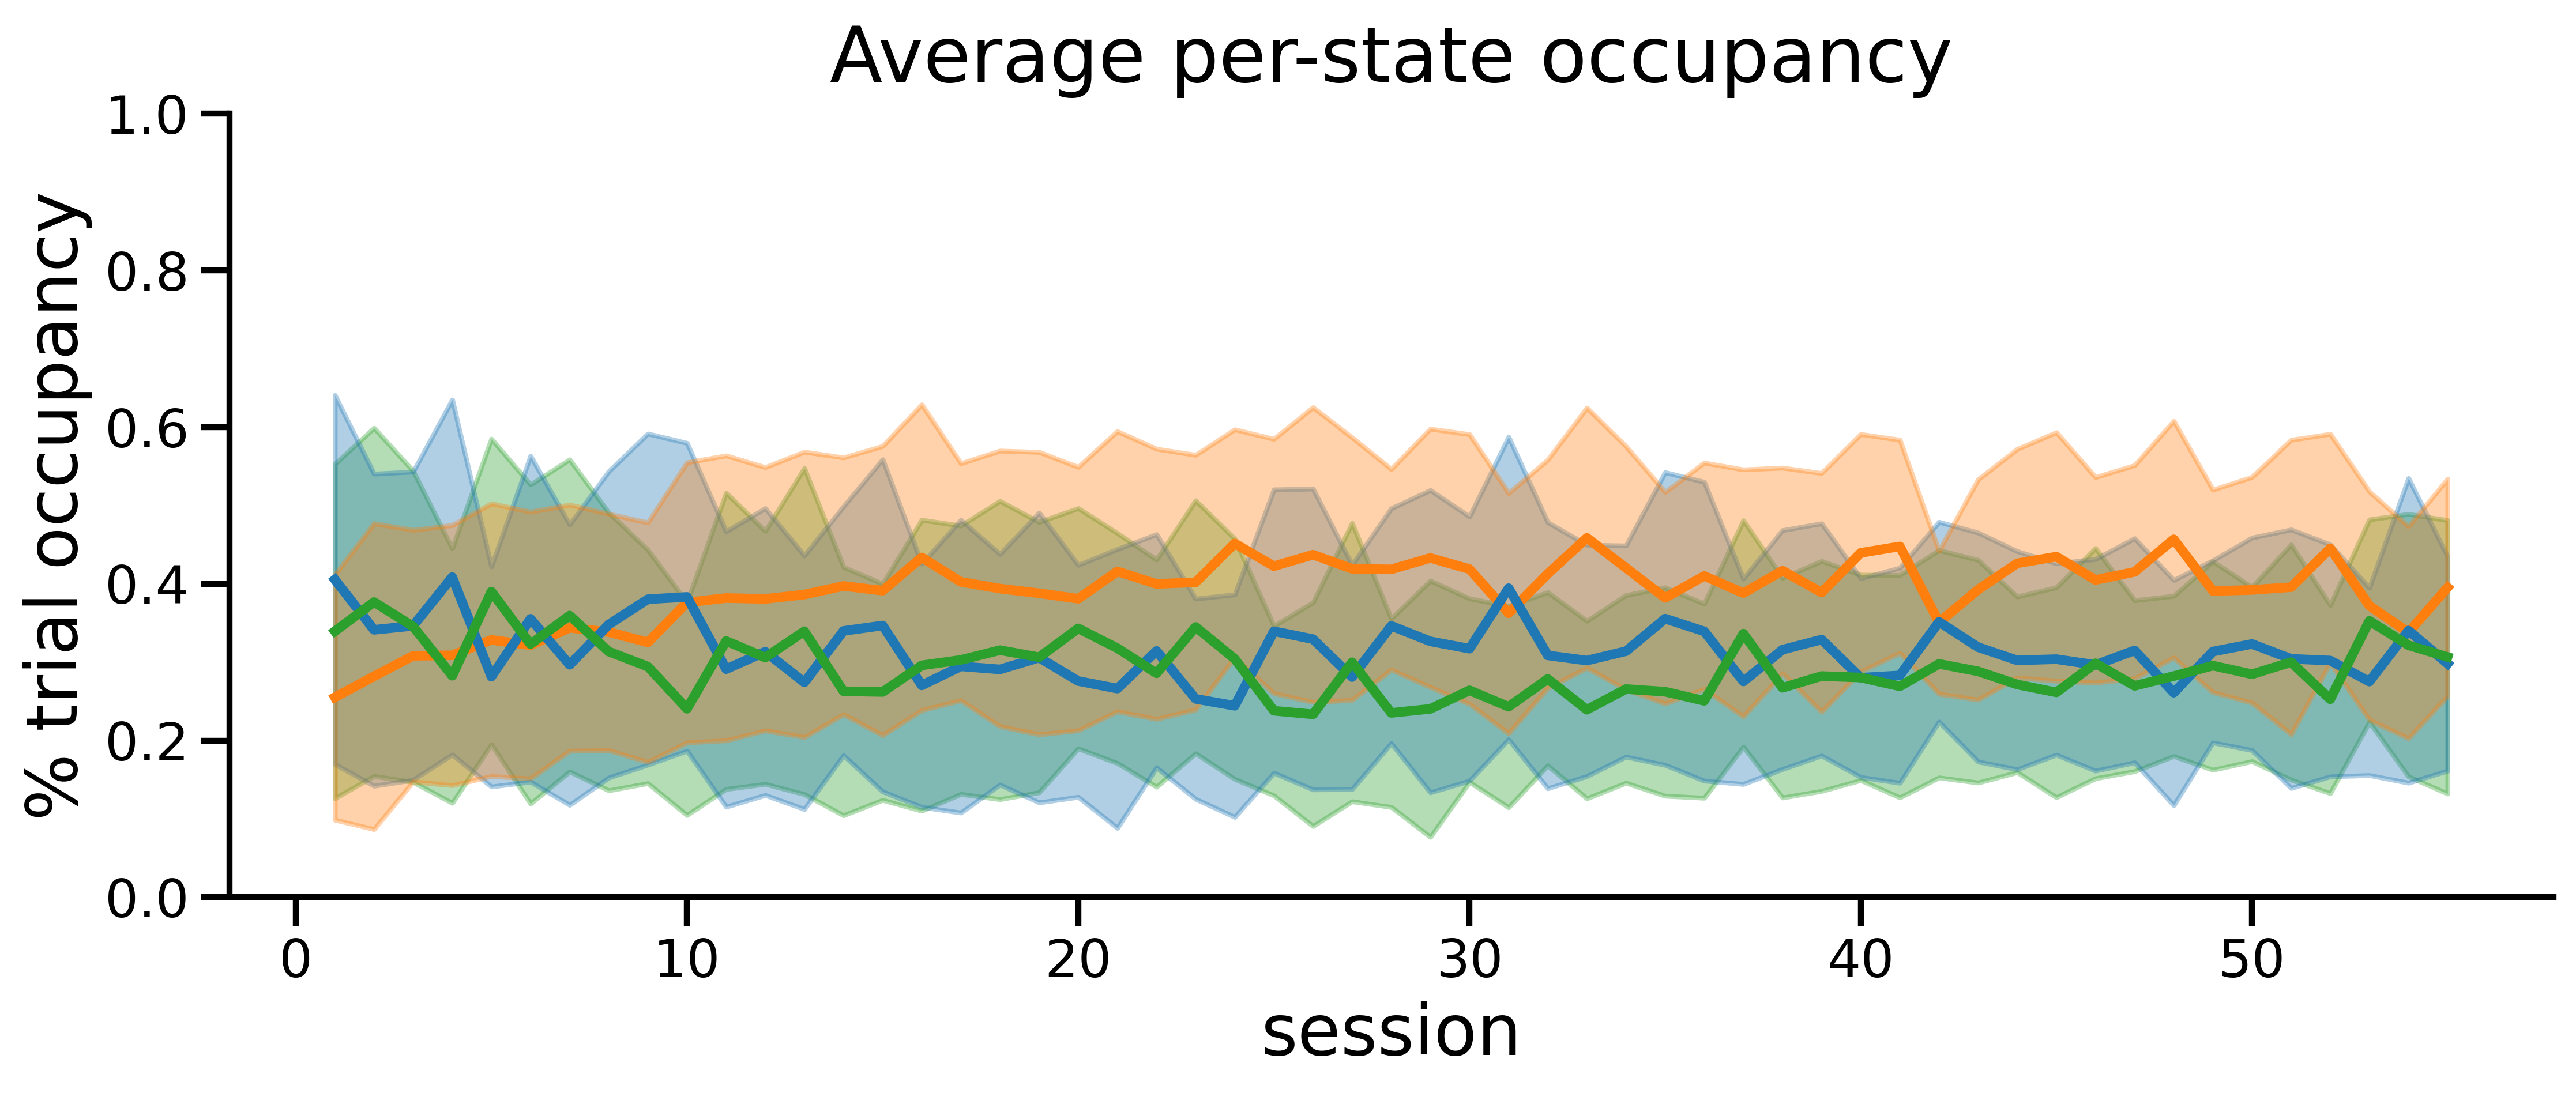

In [48]:
arrStateCount = np.ma.empty((maxSess,K,len(subjectsAll)))
arrStateCount.mask = True

arrStateSoft = np.ma.empty((maxSess,K,len(subjectsAll)))
arrStateSoft.mask = True

for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)

    stop = min(len(sessInd)-1, maxSess)
    arrStateCount[:stop, :K, idx] = allStateCount[idx][:stop]
    arrStateSoft[:stop, :K, idx] = allStateSoft[idx][:stop]

fig, axes = plt.subplots(1, figsize = (13,4.5), dpi=400)
for k in range(0,K):
    axes.plot(range(1,maxSess+1), np.nanmean(arrStateCount[:,k,:], axis=1), color=colorsStates[k], linewidth=3, label=f'state {k+1}', zorder=3)
    axes.fill_between(range(1,maxSess+1), np.nanmean(arrStateCount[:,k,:], axis=1)-np.nanstd(arrStateCount[:,k,:], axis=1), np.nanmean(arrStateCount[:,k,:], axis=1)+np.nanstd(arrStateCount[:,k,:], axis=1), alpha=0.35, zorder=2-k, color=colorsStates[k])

axes.set_ylabel('% trial occupancy', size=22)
axes.set_xlabel('session', size=22)
axes.set_ylim(0,75)
axes.legend(loc='upper left')
axes.spines[['right', 'top']].set_visible(False)
axes.get_legend().remove()
axes.set_title('Average per-state occupancy', size=24, pad=10)
# plt.savefig(f'../figures/Occupancy_states_allAnimals', bbox_inches='tight', dpi=400)

fig, axes = plt.subplots(1, figsize = (13,4.5), dpi=400)
for k in range(0,K):
    axes.plot(range(1,maxSess+1), np.nanmean(arrStateSoft[:,k,:], axis=1), color=colorsStates[k], linewidth=3, label=f'state {k+1}', zorder=3)
    axes.fill_between(range(1,maxSess+1), np.nanmean(arrStateSoft[:,k,:], axis=1)-np.nanstd(arrStateSoft[:,k,:], axis=1), np.nanmean(arrStateSoft[:,k,:], axis=1)+np.nanstd(arrStateSoft[:,k,:], axis=1), alpha=0.35, zorder=2-k, color=colorsStates[k])

axes.set_ylabel('% trial occupancy', size=22)
axes.set_xlabel('session', size=22)
axes.set_ylim(0,0.75)
axes.legend(loc='upper left')
axes.spines[['right', 'top']].set_visible(False)
axes.get_legend().remove()
axes.set_title('Average per-state occupancy', size=24, pad=10)

# Figure 4H

Text(0.5, 1.0, 'Average overall accuracy')

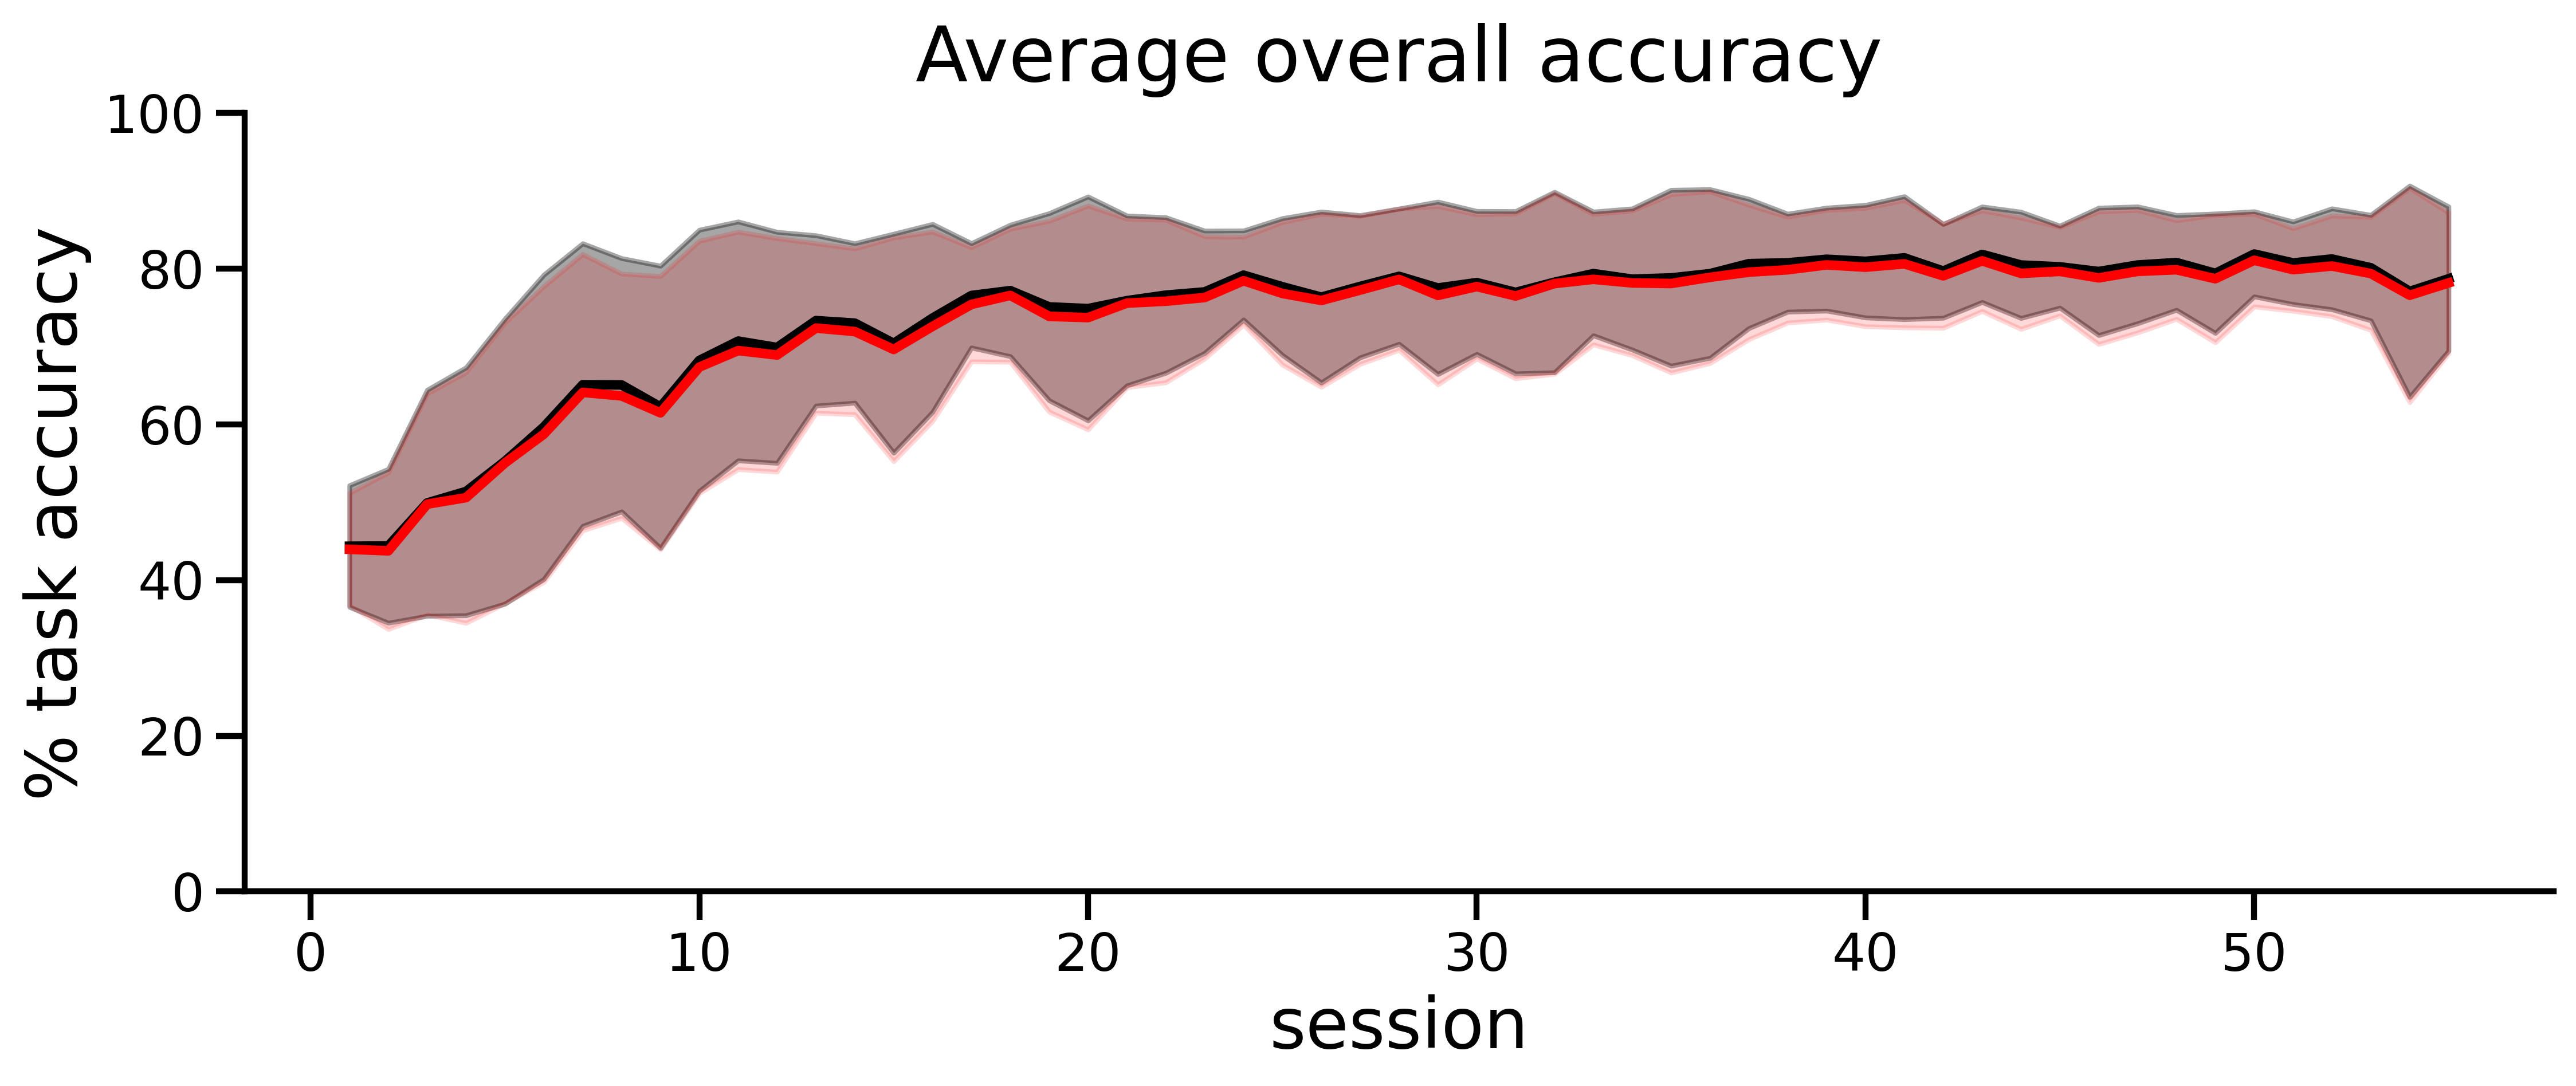

In [49]:
fig, axes = plt.subplots(1, figsize = (13,4.5), dpi=400)
axes.plot(range(1,maxSess+1), np.nanmean(arrOverallCorrect, axis=1), color='black', linewidth=3,  zorder=3)
axes.plot(range(1,maxSess+1), np.nanmean(arrEmpiricalCorrect, axis=1), color='red', linewidth=3,  zorder=3)
axes.fill_between(range(1,maxSess+1), np.nanmean(arrOverallCorrect, axis=1) - np.nanstd(arrOverallCorrect, axis=1), np.nanmean(arrOverallCorrect, axis=1) + np.nanstd(arrOverallCorrect, axis=1), alpha=0.35, zorder=2-k, color='black')
axes.fill_between(range(1,maxSess+1), np.nanmean(arrEmpiricalCorrect, axis=1) - np.nanstd(arrEmpiricalCorrect, axis=1), np.nanmean(arrEmpiricalCorrect, axis=1) + np.nanstd(arrEmpiricalCorrect, axis=1), alpha=0.15, zorder=2-k, color='red')

# axes[1].plot(range(1,len(sessInd)), p_correct_sessions, color='black', linewidth=3)
axes.set_ylim(0,100)
axes.set_ylabel('% task accuracy ', size=22)
axes.set_xlabel('session', size=22)

axes.spines[['right', 'top']].set_visible(False)
axes.set_title('Average overall accuracy', size=24, pad=10)
# plt.savefig(f'../figures/Overall_accuracy_states_allAnimals', bbox_inches='tight', dpi=400)

In [63]:
# Computing test log likelihood per session for 1 state and 3 state models

# number of sessions to look at 
sessInterest = 30

testLl_sessions = np.ma.empty((len(subjectsAll), 3, sessInterest, splitFolds))
testLl_sessions.mask = True

bestAlphaInd = 2

for idx in range(0, len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh) # NOT LOOKING AT FULL DATASET
    N = x.shape[0]
    sess = len(sessInd) - 1
    presentTrain, presentTest = split_data(N, sessInd, folds=splitFolds, blocks=10, random_state=1)
    stop = min(sessInterest, sess)

    for fold in range(0, splitFolds):
        # data3 = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_3-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        # data2 = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_2-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        # data1 = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_1-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        # testLl_sessions[idx,2,:stop,fold] =  data3['testLlSessions'][bestSigmaInd,0:stop]
        # testLl_sessions[idx,1,:stop,fold] =  data2['testLlSessions'][bestSigmaInd,0:stop]
        # testLl_sessions[idx,0,:stop,fold] =  data1['testLlSessions'][bestSigmaInd,0:stop]

        data3 = np.load(f'../data_IBL/{subject}/{subject}_dynamicGLMHMM_CV_3-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        data2 = np.load(f'../data_IBL/{subject}/{subject}_dynamicGLMHMM_CV_2-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        data1 = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_1-state_fold={fold}_pTanh={pTanh}_signedStimulus={signedStimulus}.npz')
        testLl_sessions[idx,2,:stop,fold] =  data3['testLlSessions'][bestAlphaInd,0:stop]
        testLl_sessions[idx,1,:stop,fold] =  data2['testLlSessions'][bestAlphaInd,0:stop]
        testLl_sessions[idx,0,:stop,fold] =  data1['testLlSessions'][bestSigmaInd,0:stop]



# Figure 5A

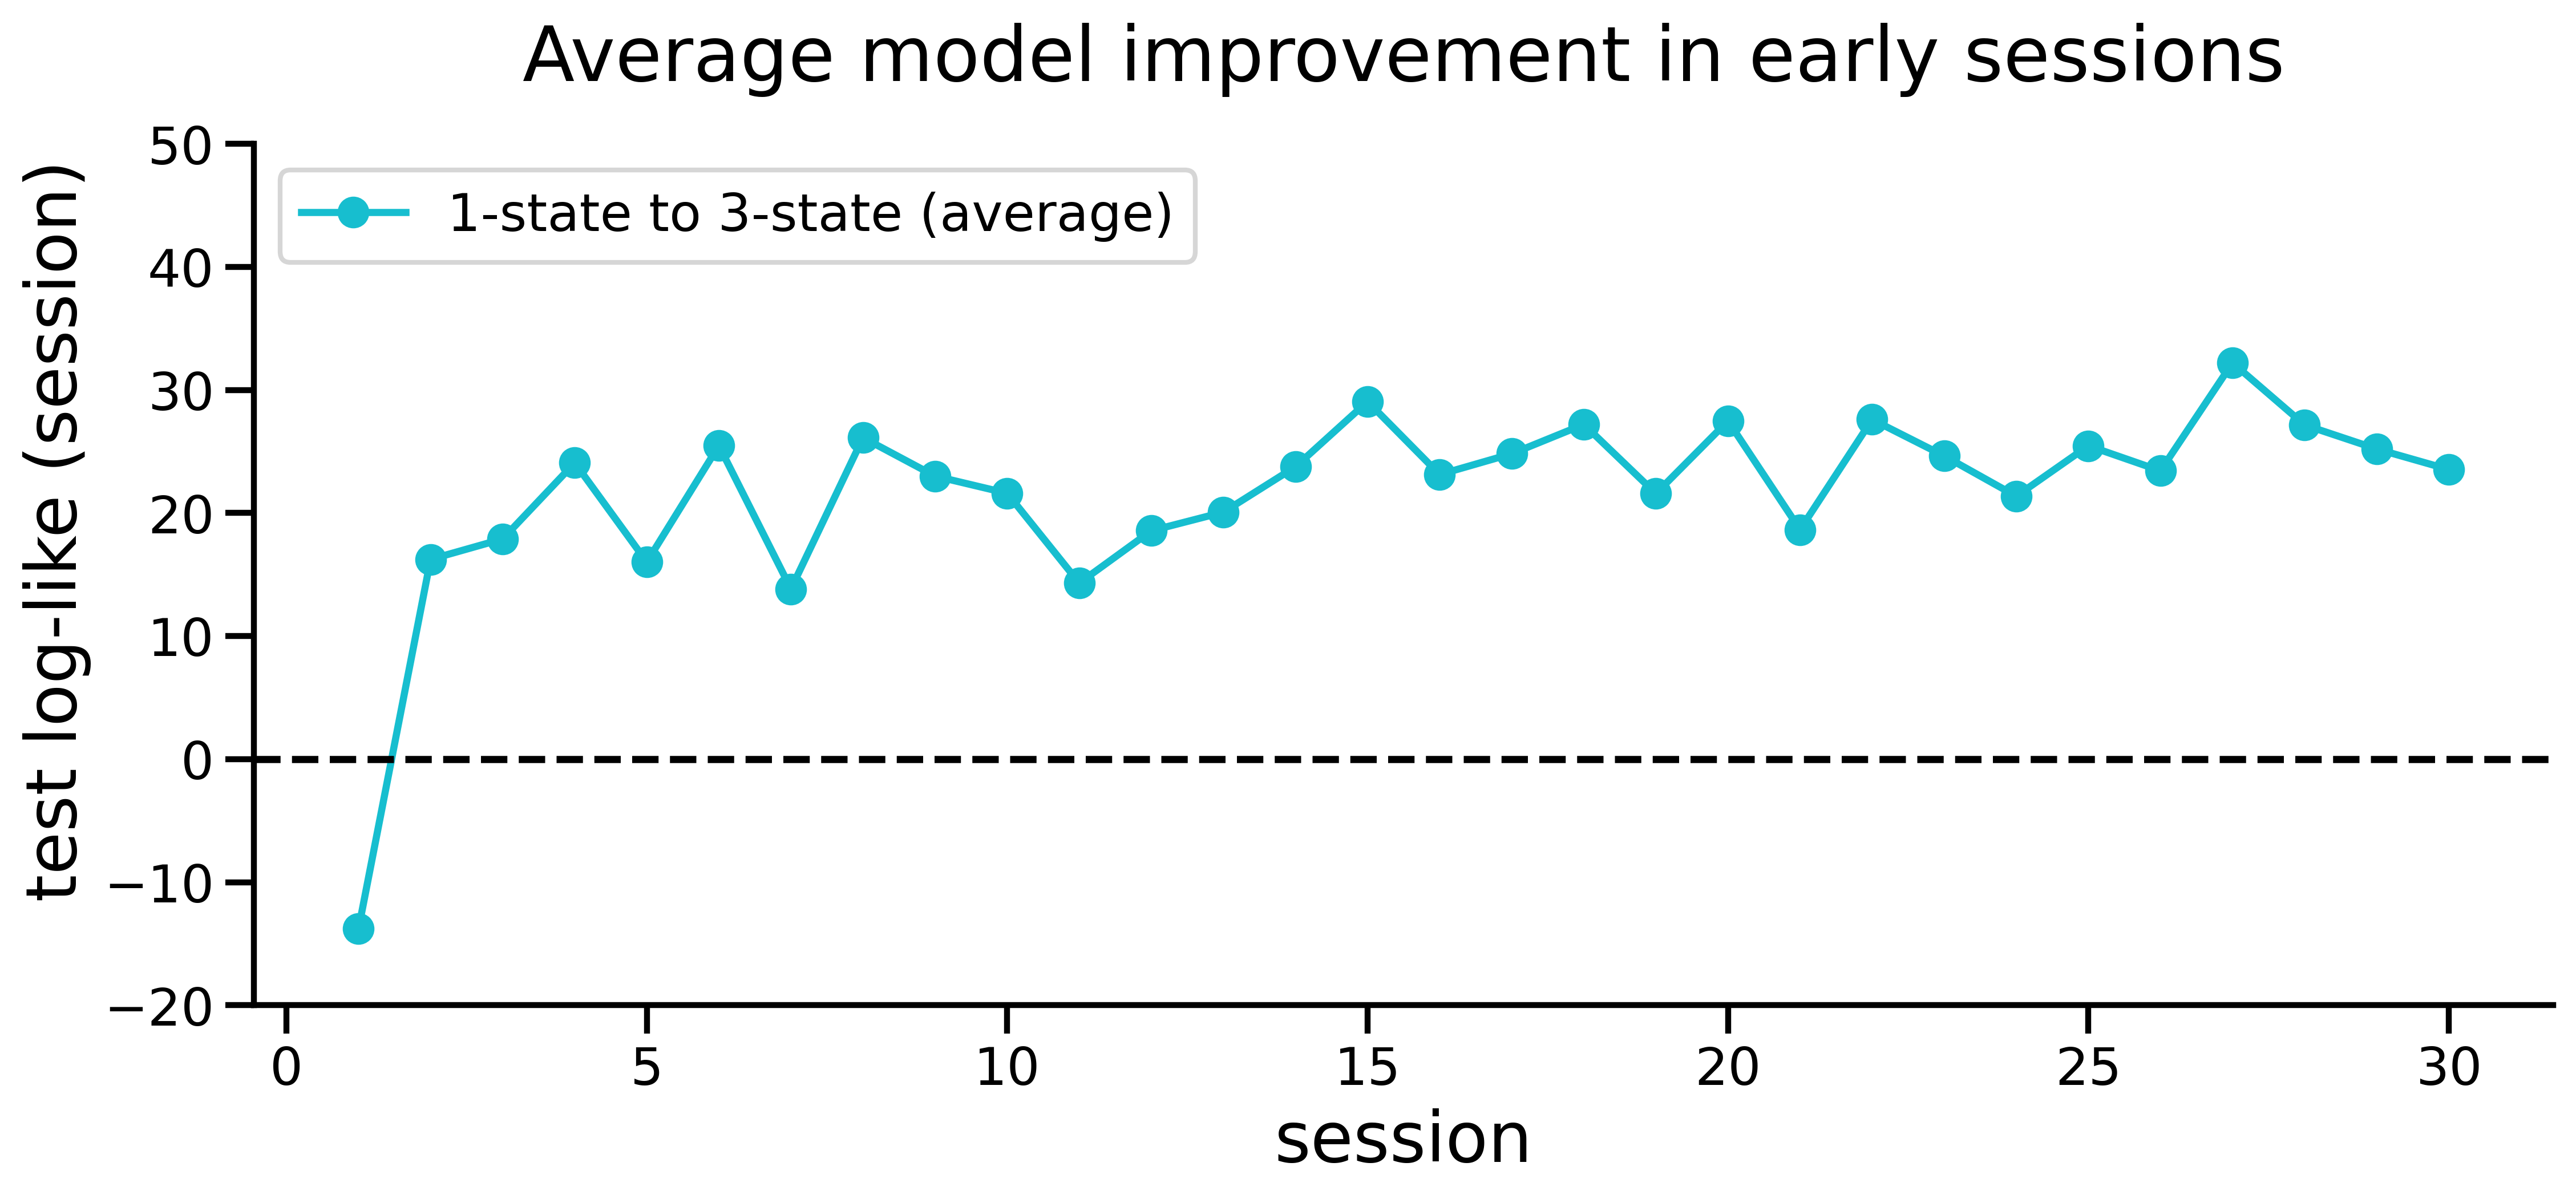

In [66]:
fig, axes = plt.subplots(1, figsize = (13,5), dpi=400)
avgTestLl = np.nanmean(testLl_sessions, axis=3) # averaging across folds
# for idx in range(0, len(subjectsAll)):
#     axes.plot(range(1,sessInterest+1), (avgTestLl[idx, 2, :] - avgTestLl[idx, 0, :]) * avg_session_length, '-', color = colormap[2], alpha=0.1)
    # axes.plot(range(1,sessInterest+1), (avgTestLl[idx, 1, :] - avgTestLl[idx, 0, :]) * avg_session_length, '-', color = colormap[1], alpha=0.1)
avgTestLl = np.nanmean(avgTestLl, axis = 0) # averaging across animals
axes.plot(range(1,sessInterest+1), (avgTestLl[2] - avgTestLl[0]) * avg_session_length, '-o', color = colormap[2], label='1-state to 3-state (average)')
# axes.plot(range(1,sessInterest+1), (avgTestLl[1] - avgTestLl[0]) * avg_session_length, '-o', color = colormap[1], label='1-state to 2-state (average)')
axes.set_xlabel('session', size=22)
axes.set_ylabel('    test log-like (session)', size=22)
axes.legend(loc='upper left')
axes.axhline(0, color='black', linestyle='dashed')
axes.set_title('Average model improvement in early sessions', size=24, pad=20)
axes.spines[['right', 'top']].set_visible(False)
axes.set_xticks(range(0,31,5),range(0,31,5))
axes.set_ylim(-20,50)
plt.savefig(f'../figures/Test_Log-Like_1vs3states_early_sessions_allAnimals', bbox_inches='tight', dpi=400)

# Figure 5B

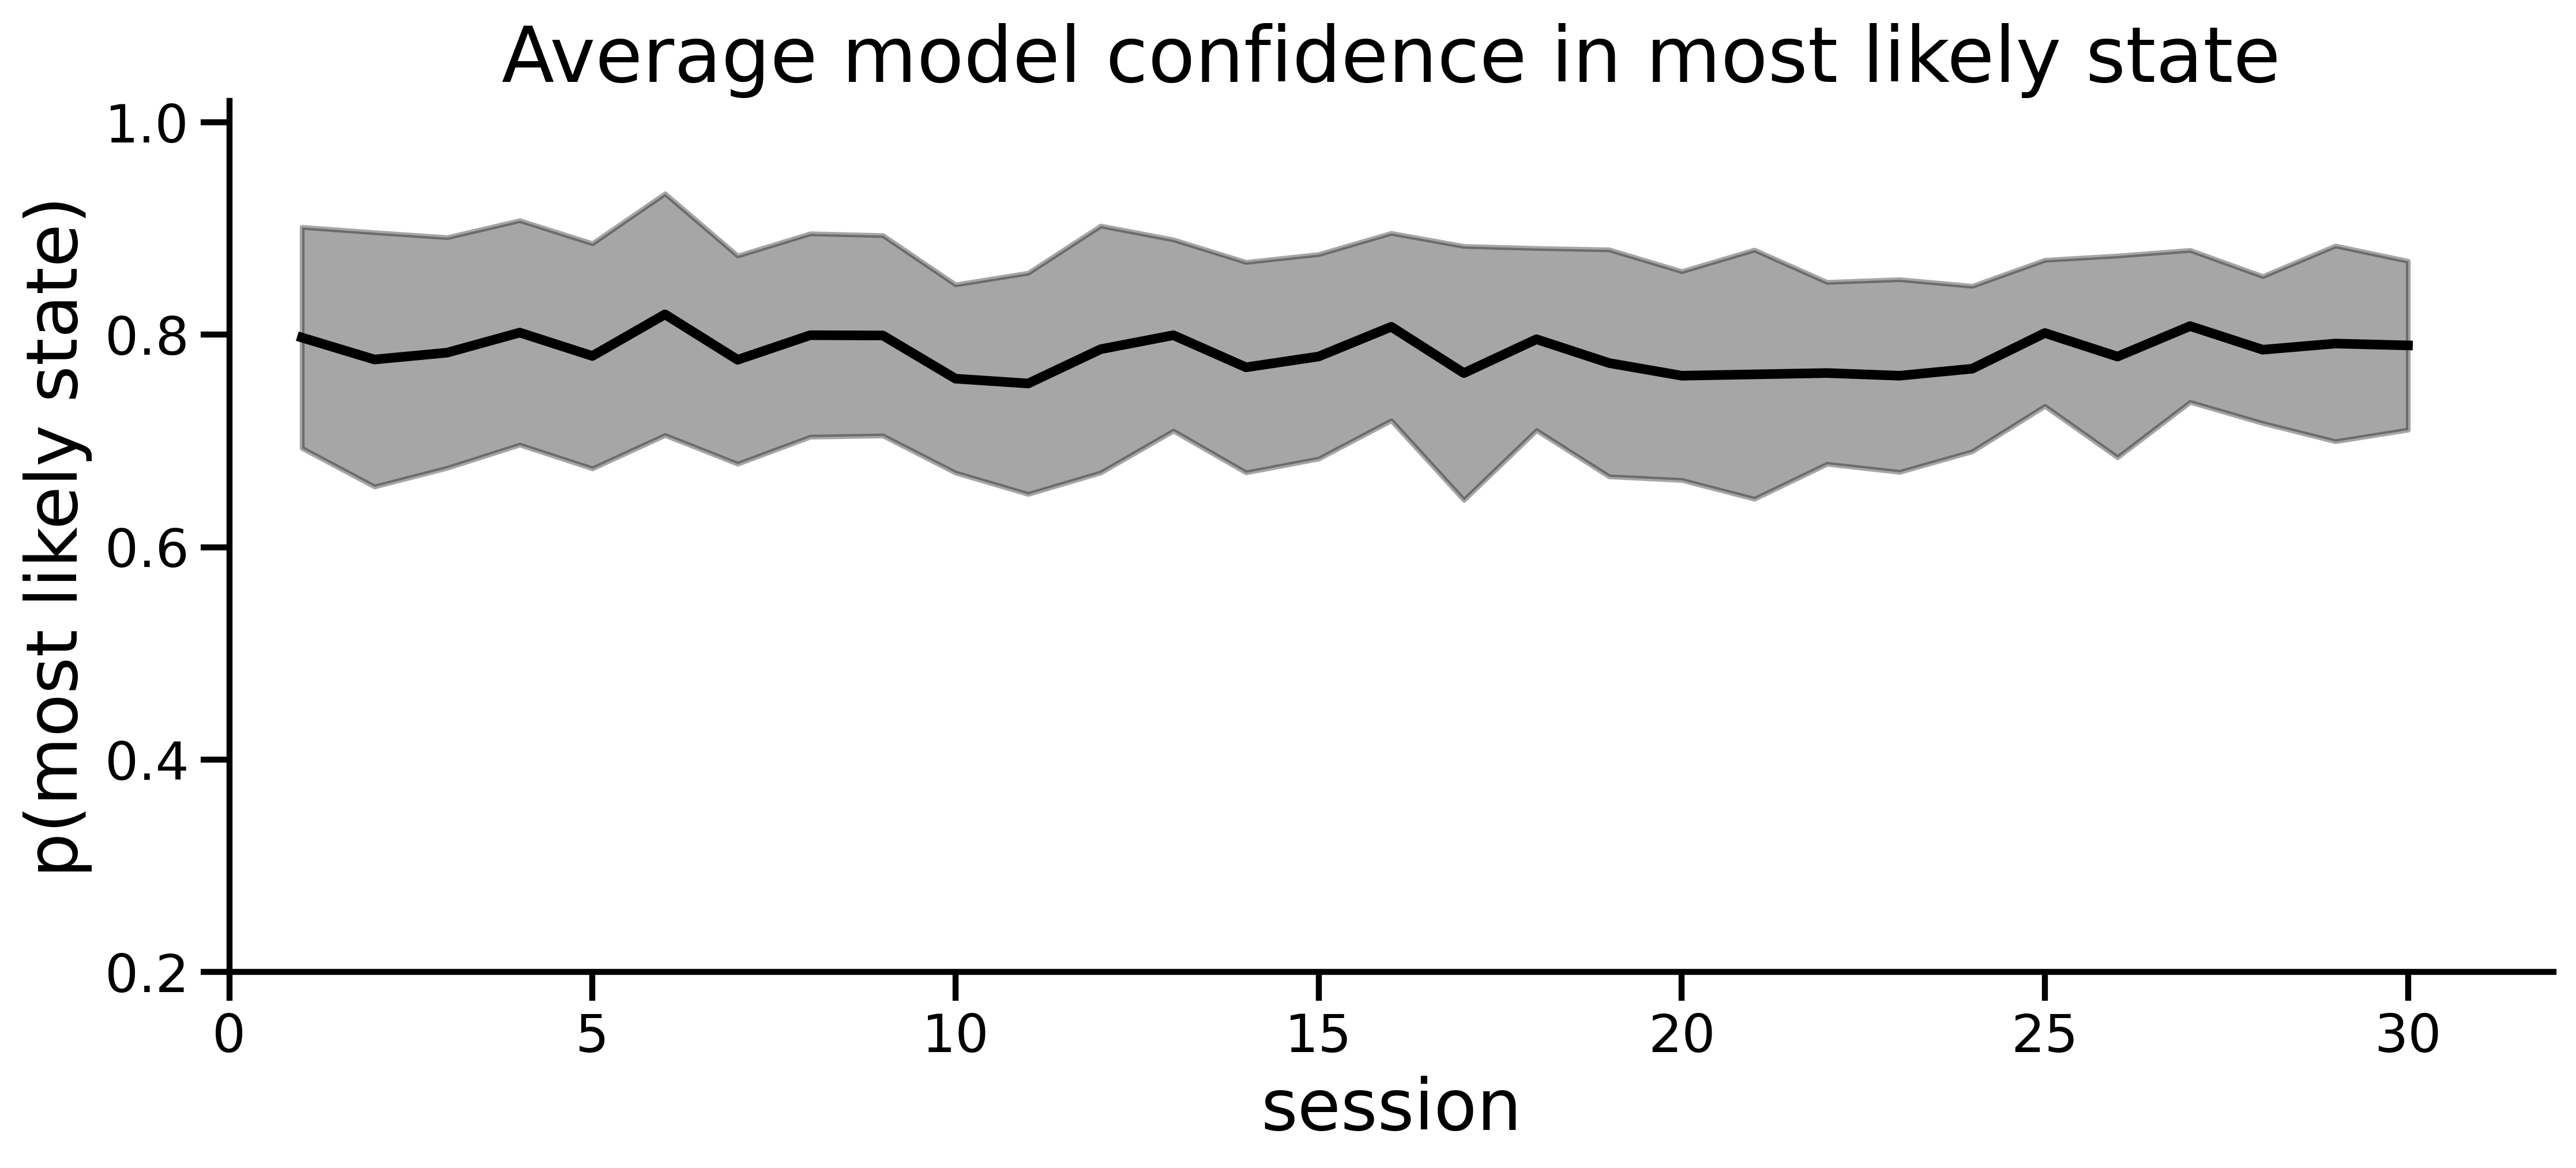

In [69]:
# Probability of most likely state - average across animals and within session
arrProbStateMax = np.ma.empty((sessInterest, len(subjectsAll)))
arrProbStateMax.mask = True

fig, axes = plt.subplots(1) 
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)

    probMaxSession = distribution_most_likely_state(allGamma[idx], sessInd, axes)
    
    stop = min(len(sessInd)-1, sessInterest)
    arrProbStateMax[:stop, idx] = probMaxSession[:stop]
plt.close()

fig, axes = plt.subplots(1, figsize = (13,5), sharex=True, dpi=400) 
axes.plot(range(1,sessInterest+1), np.nanmean(arrProbStateMax, axis=1), color='black', linewidth=3)
axes.fill_between(range(1,sessInterest+1), np.nanmean(arrProbStateMax, axis=1)-np.nanstd(arrProbStateMax, axis=1), np.nanmean(arrProbStateMax, axis=1)+np.nanstd(arrProbStateMax, axis=1), alpha=0.35, color='black')
axes.spines[['right', 'top']].set_visible(False)
axes.set_xlabel('session', size=22)
axes.set_ylabel('p(most likely state)', size=22)
axes.set_ylim(0.2,1.02)
axes.set_xlim(0,sessInterest+2)
axes.set_title('Average model confidence in most likely state', size=24)
axes.set_xticks(range(0,31,5),range(0,31,5))
# plt.savefig(f'../figures/Probability_most_likely_state_allAnimals', bbox_inches='tight', dpi=400)


In [72]:
from scipy import stats
test_ll_animal = np.nanmean(testLl_sessions, axis=3) # average across folds

# first session in which 3-state model outperforms the 1-state one
first_session_better_3 = np.zeros((len(subjectsAll)))
for idx in range(len(subjectsAll)):
    for s in range(sessInterest):
        if test_ll_animal[idx, 2, s] > test_ll_animal[idx, 0, s]:
            first_session_better_3[idx] = s+1
            break
#first session in which state 1 outperforms the other states
first_session_better_engaged = np.zeros((len(subjectsAll)))
for idx in range(len(subjectsAll)):
    for s in range(sessInterest):
        if arrStateCorrect[idx,0,s] > arrStateCorrect[idx,1,s] and arrStateCorrect[idx,0,s] > arrStateCorrect[idx,2,s]:
            first_session_better_engaged[idx] = s+1
            break


# Figure 5C

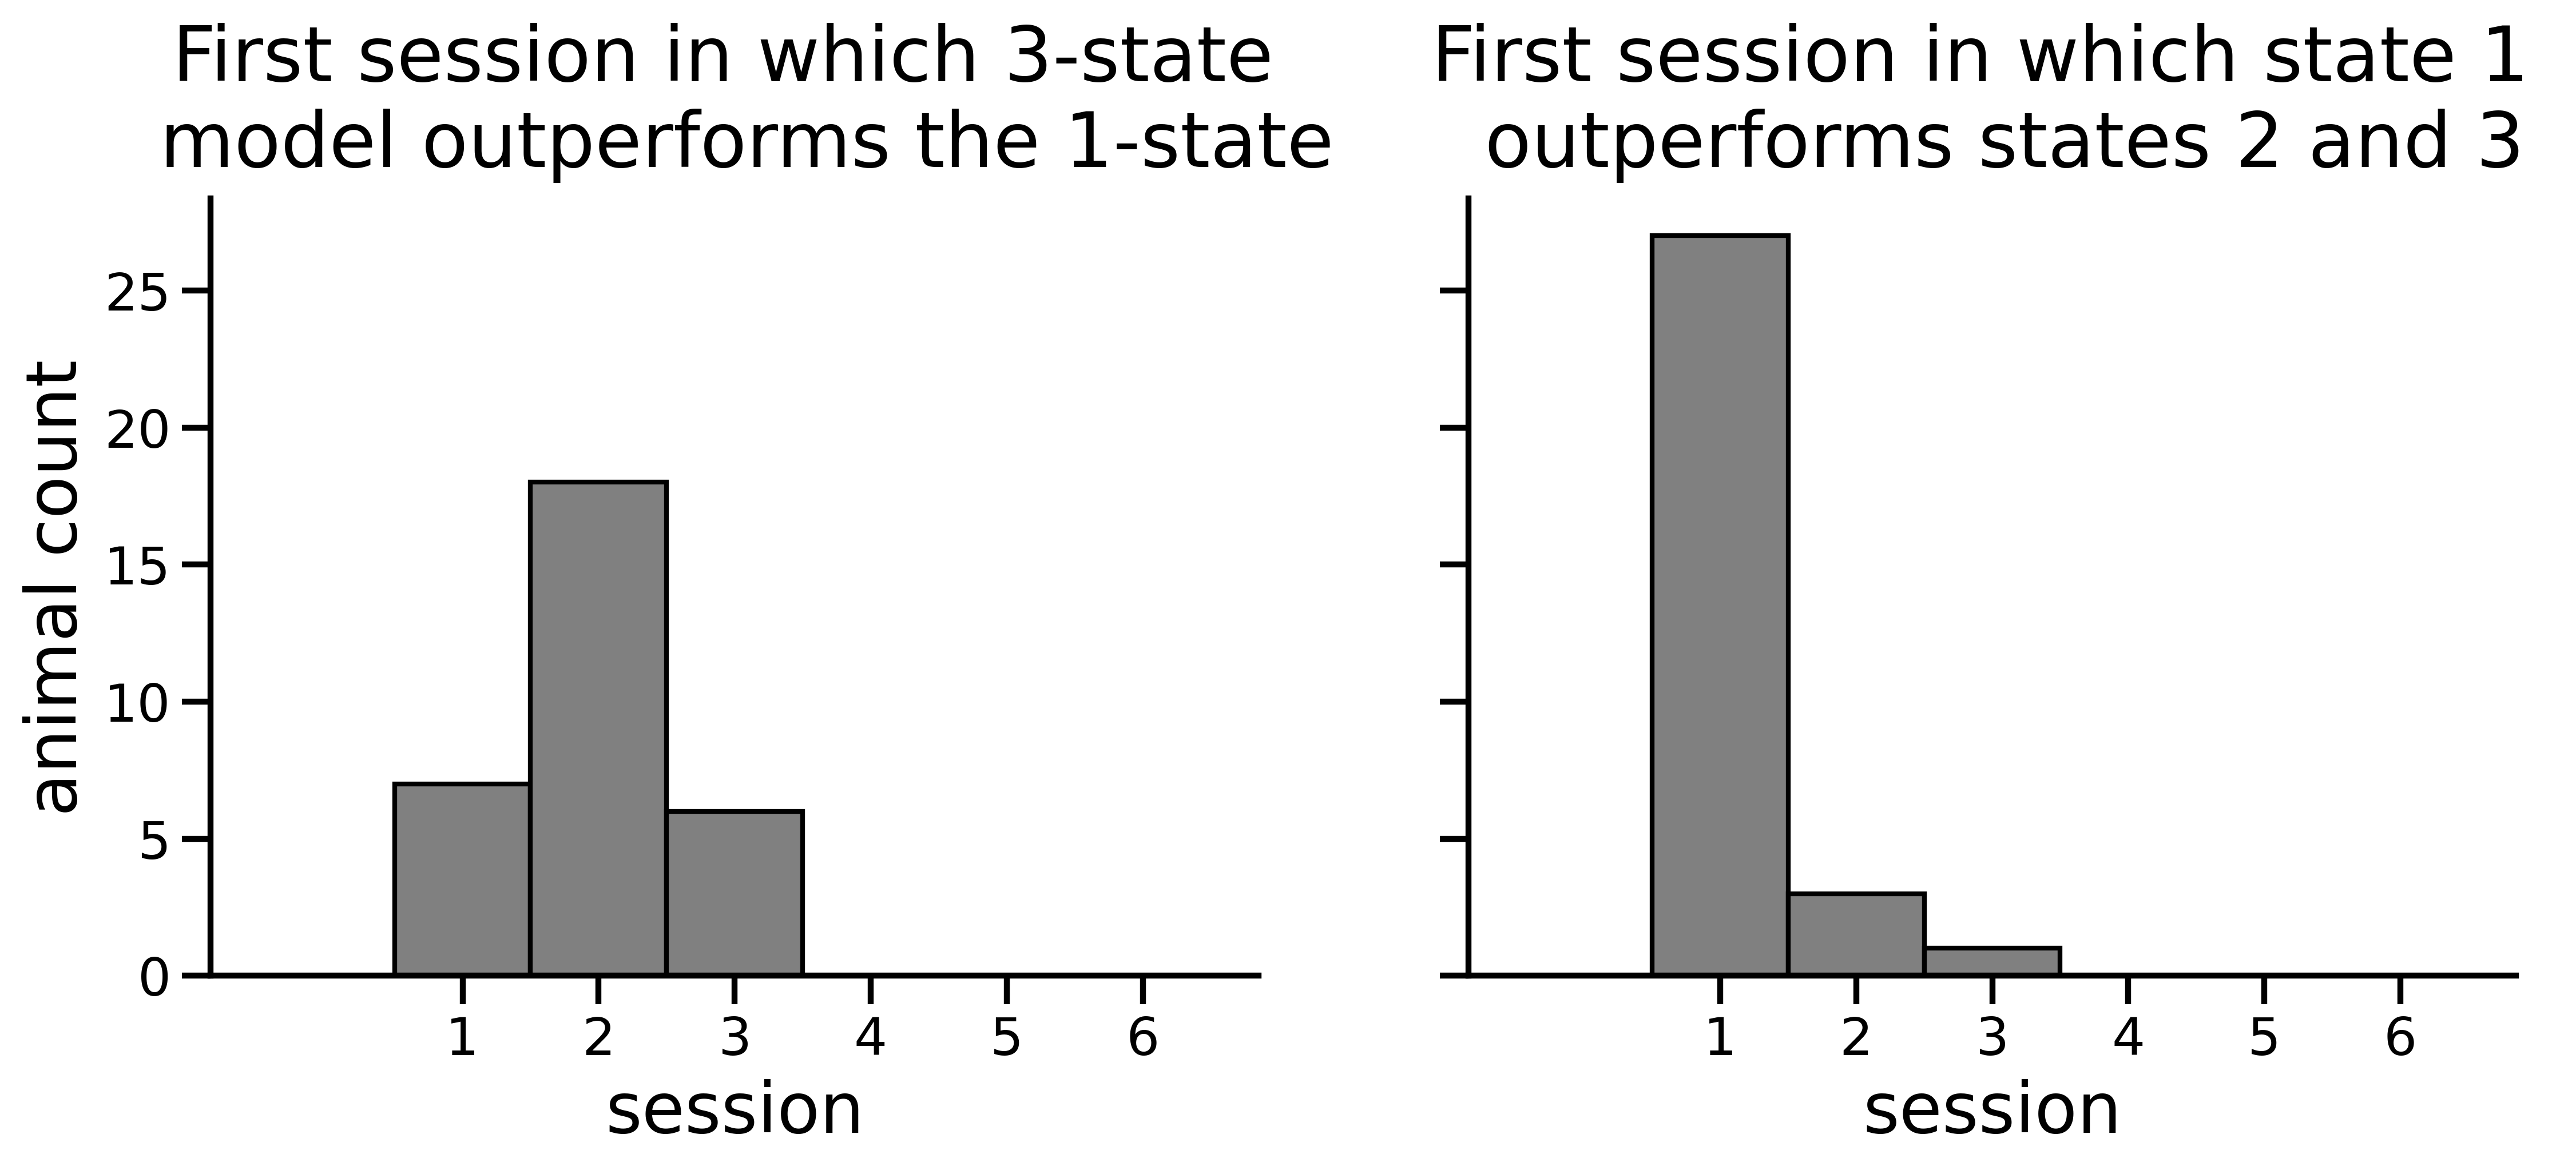

In [73]:
fig, axes = plt.subplots(1, 2, figsize = (13,4.5), dpi=400, sharey=True)
axes[0].hist(first_session_better_3, bins=list(np.arange(-0.5,7.5,1)), color='gray', edgecolor='black')
axes[0].set_xlabel('session', size=22)
axes[0].set_ylabel('animal count', size=22)
axes[0].set_title('First session in which 3-state \n model outperforms the 1-state', size=24, pad=10)
axes[0].set_xticks([1,2,3,4,5,6], [1,2,3,4,5,6])
axes[0].spines[['right', 'top']].set_visible(False)

axes[1].hist(first_session_better_engaged, bins=list(np.arange(-0.5,7.5,1)), color='gray', edgecolor='black')
axes[1].set_xlabel('session', size=22)
axes[1].set_title('First session in which state 1 \n outperforms states 2 and 3', size=24, pad=10)
axes[1].set_xticks([1,2,3,4,5,6], [1,2,3,4,5,6])
axes[1].spines[['right', 'top']].set_visible(False)
# plt.savefig(f'../figures/Histogram_First_Session_allAnimals', bbox_inches='tight', dpi=400)

# Figure 5D

Text(0.5, 1.0, 'Average per-state occupancy during early sessions')

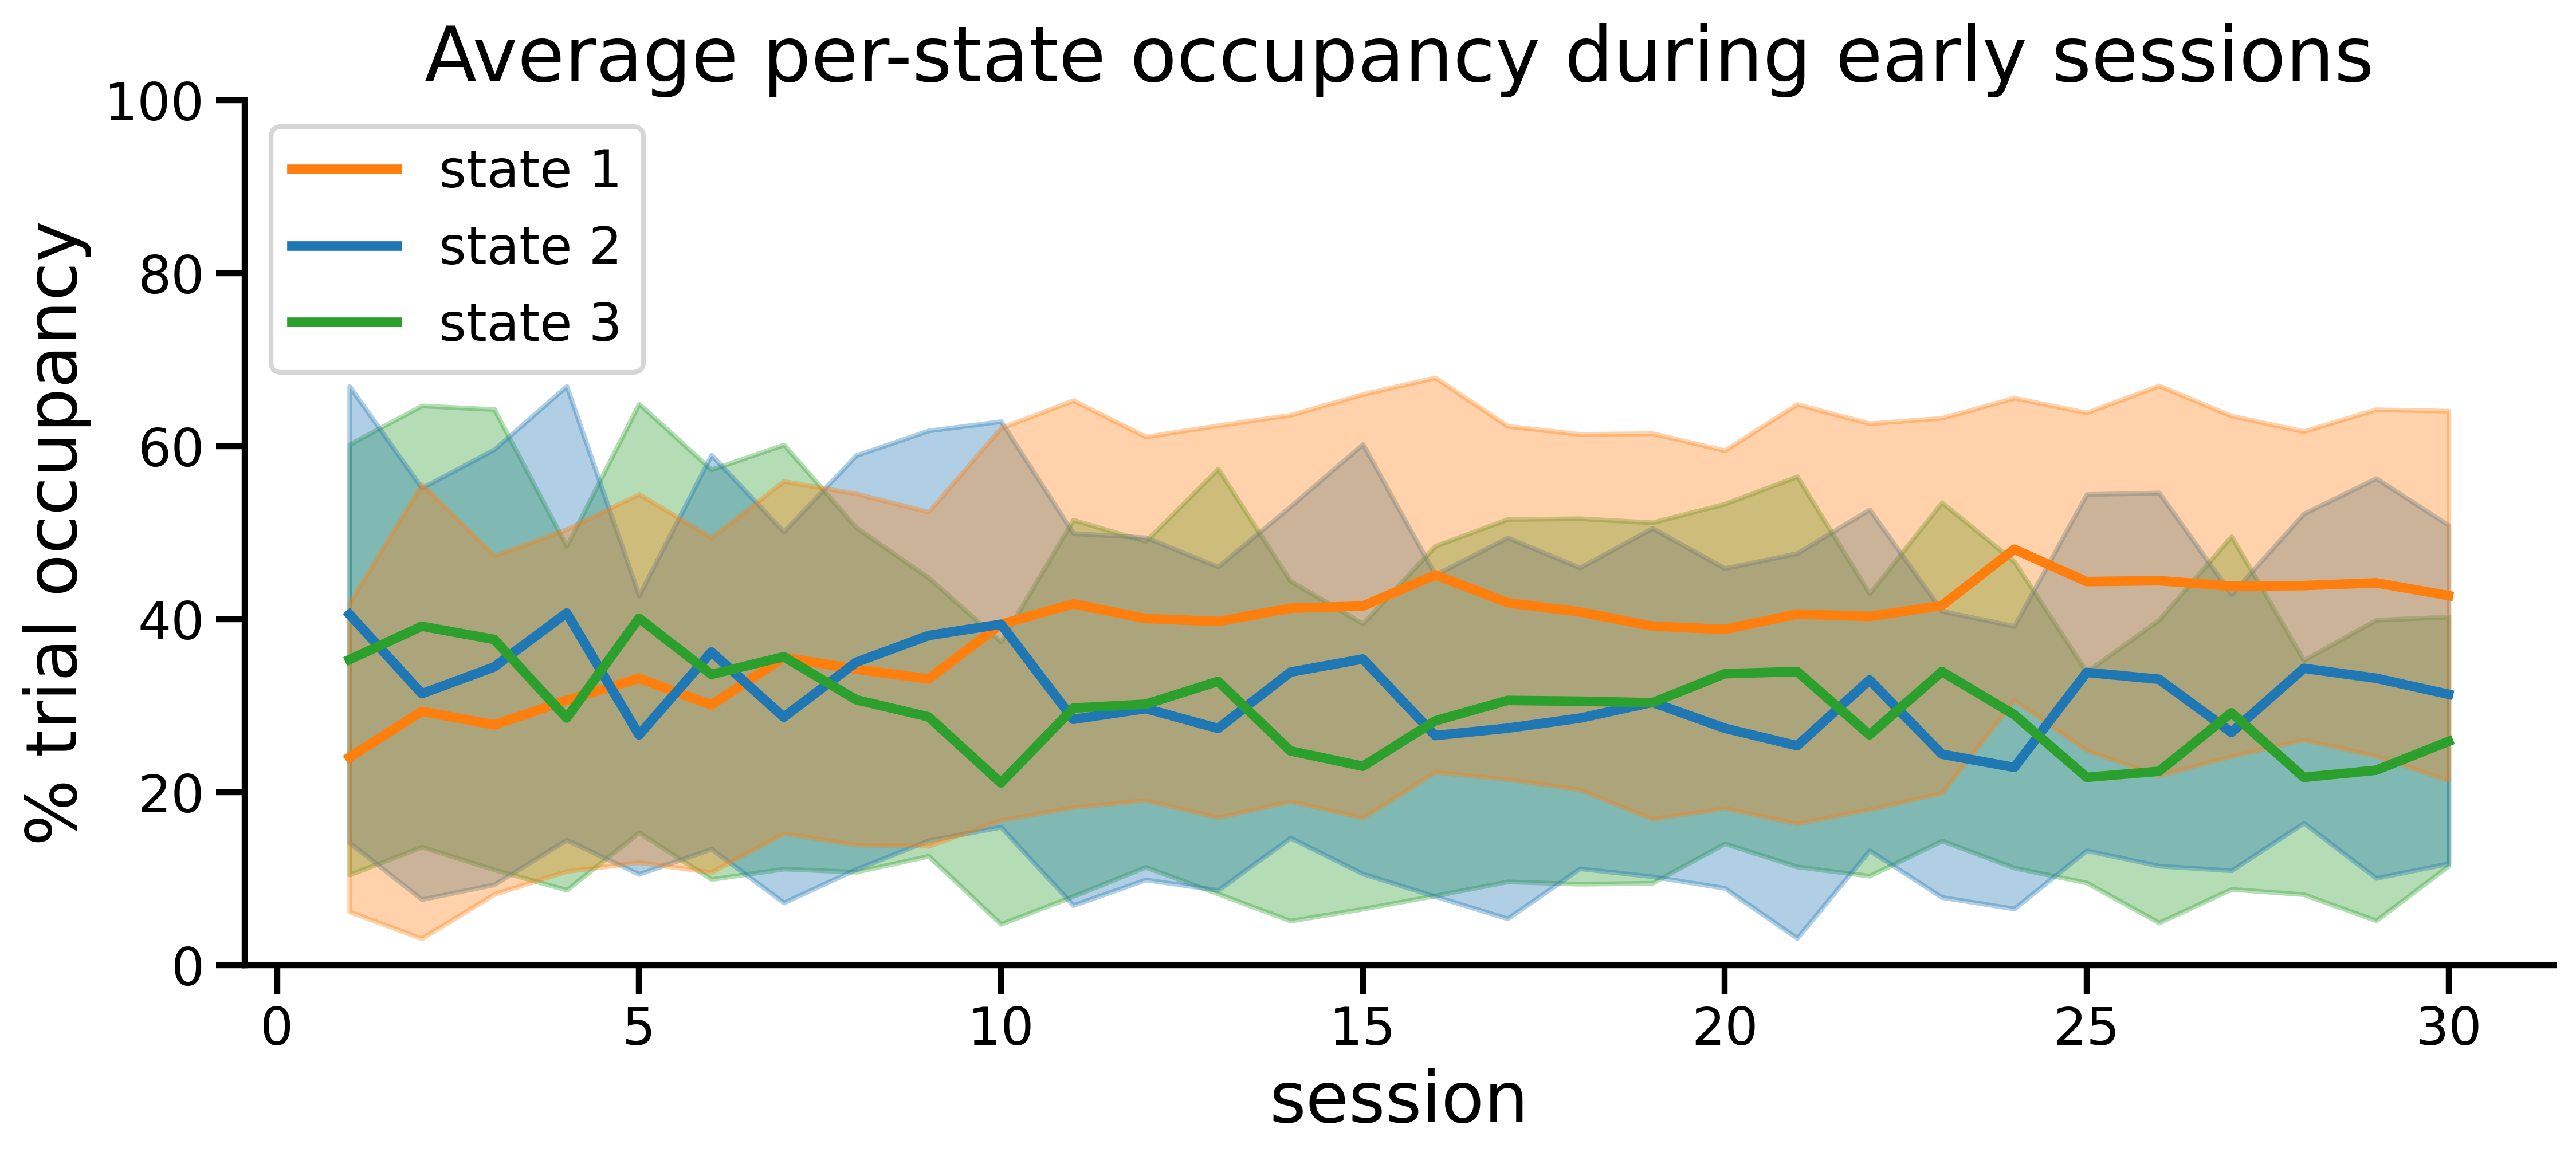

In [59]:
fig, axes = plt.subplots(1, figsize = (13,5), sharex=True, dpi=400) 
for k in range(0,K):
    axes.plot(range(1,sessInterest+1), np.nanmean(arrStateCount[:sessInterest,k,:], axis=1), color=colorsStates[k], linewidth=3, label=f'state {k+1}', zorder=3)
    axes.fill_between(range(1,sessInterest+1), np.nanmean(arrStateCount[:sessInterest,k,:], axis=1)-np.nanstd(arrStateCount[:sessInterest,k,:], axis=1), np.nanmean(arrStateCount[:sessInterest,k,:], axis=1)+np.nanstd(arrStateCount[:sessInterest,k,:], axis=1), alpha=0.35, zorder=2-k, color=colorsStates[k])

axes.set_ylabel('% trial occupancy', size=22)
axes.set_ylim(0,100)
axes.legend(loc='upper left')
axes.set_xlabel('session', size=22)
axes.spines[['right', 'top']].set_visible(False)
axes.set_xticks(range(0,31,5),range(0,31,5))
axes.set_title('Average per-state occupancy during early sessions', size=24)
# plt.savefig(f'../figures/Occupancy_earlySessions_allAnimals', bbox_inches='tight', dpi=400)


In [60]:
# Computing accuracy for easy and hard trials separately
maxSess = 55

arrStateSeparateCorrect = np.ma.empty((maxSess,K,len(subjectsAll), 2))
arrStateSeparateCorrect.mask = True

arrOverallSeparateCorrect = np.ma.empty((maxSess,len(subjectsAll), 2))
arrOverallSeparateCorrect.mask = True


for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)

    stop = min(len(sessInd)-1, maxSess)
    arrStateSeparateCorrect[:stop, :K, idx, 0] = allStateCorrectSeparate[idx, 0][:stop] # hard trials
    arrStateSeparateCorrect[:stop, :K, idx, 1] = allStateCorrectSeparate[idx, 1][:stop] # easy trials
    arrOverallSeparateCorrect[:stop, idx, 0] = allOverallCorrectSeparate[idx, 0][:stop]
    arrOverallSeparateCorrect[:stop, idx, 1] = allOverallCorrectSeparate[idx, 1][:stop]



# Figure 5E

Text(0.5, 1.0, 'Average accuracy on easy trials vs all trials')

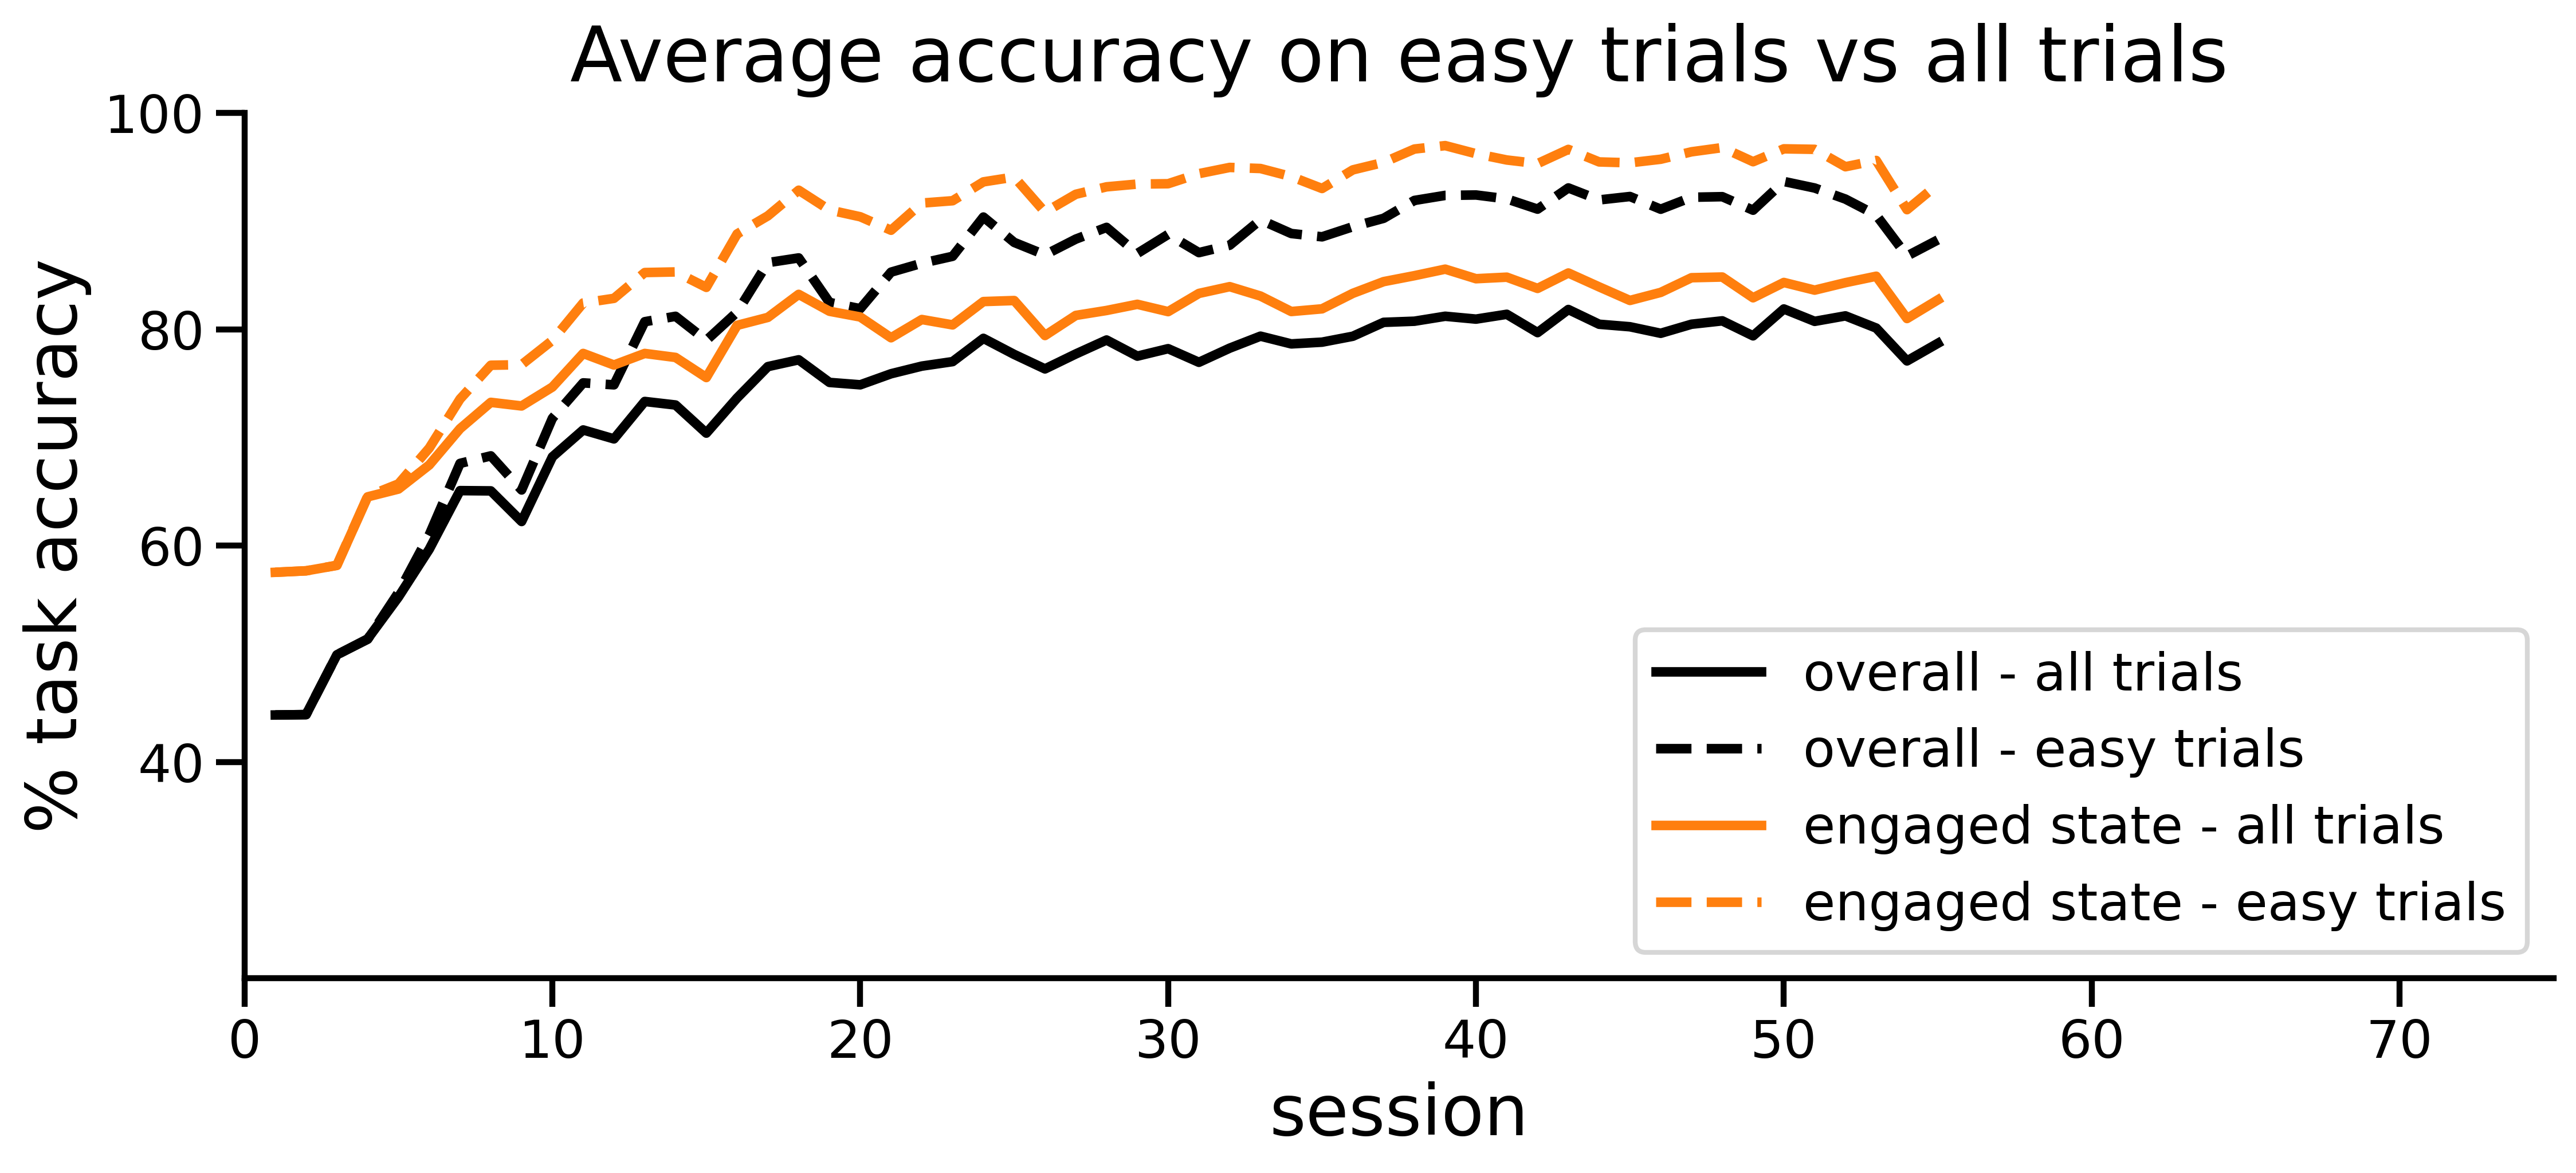

In [61]:
fig, axes = plt.subplots(1, figsize = (13,5), dpi=400) 

# overall accuracy
# axes.fill_between(range(1,maxSess+1), np.nanmean(arrOverallCorrect, axis=1)-np.nanstd(arrOverallCorrect, axis=1), np.nanmean(arrOverallCorrect, axis=1)+np.nanstd(arrOverallCorrect, axis=1), alpha=0.2, zorder=0, color="gray")
axes.plot(range(1,maxSess+1), np.nanmean(arrOverallCorrect, axis=1), color="black", linewidth=3, label='overall - all trials', zorder=1)
# axes.fill_between(range(1,maxSess+1), np.nanmean(arrOverallSeparateCorrect[:,:,1], axis=1)-np.nanstd(arrOverallSeparateCorrect[:,:,1], axis=1), np.nanmean(arrOverallSeparateCorrect[:,:,1], axis=1)+np.nanstd(arrOverallSeparateCorrect[:,:,1], axis=1), alpha=0.2, zorder=0, color="black")
axes.plot(range(1,maxSess+1), np.nanmean(arrOverallSeparateCorrect[:,:,1], axis=1), color="black", linewidth=3, label='overall - easy trials', zorder=1, linestyle='--')


# accuracy in state 1
# axes.fill_between(range(1,maxSess+1), np.nanmean(arrStateCorrect[:,0,:], axis=1)-np.nanstd(arrStateCorrect[:,0,:], axis=1), np.nanmean(arrStateCorrect[:,0,:], axis=1)+np.nanstd(arrStateCorrect[:,0,:], axis=1), alpha=0.2, zorder=0, color="orange")
axes.plot(range(1,maxSess+1), np.nanmean(arrStateCorrect[:,0,:], axis=1), color="tab:orange", linewidth=3, label='engaged state - all trials', zorder=1)
# axes.fill_between(range(1,maxSess+1), np.nanmean(arrStateSeparateCorrect[:,0,:,1], axis=1)-np.nanstd(arrStateSeparateCorrect[:,0,:,1], axis=1), np.nanmean(arrStateSeparateCorrect[:,0,:,1], axis=1)+np.nanstd(arrStateSeparateCorrect[:,0,:,1], axis=1), alpha=0.2, zorder=0, color='tab:orange')
axes.plot(range(1,maxSess+1), np.nanmean(arrStateSeparateCorrect[:,0,:,1], axis=1), color="tab:orange", linewidth=3, label='engaged state - easy trials', zorder=1, linestyle='--')

axes.set_ylabel('% task accuracy', size=22)
axes.set_xlabel('session', size=22)
axes.set_yticks([40,60,80,100])
axes.set_ylim(20,100)
axes.set_xlim(0,55)
axes.axhline(0.5, color="black", linestyle="--", lw=1, alpha=0.3, zorder=0)
axes.spines[['right', 'top']].set_visible(False)
axes.legend(loc='lower right')
axes.set_title('Average accuracy on easy trials vs all trials' ,size=24, pad=10)
# plt.savefig(f'../figures/Accuracy_TotalvsEngaged_allAnimals', bbox_inches='tight', dpi=400)

In [64]:
# identities of labs
subjectsAll = []
labChosen =  ['angelakilab','churchlandlab','wittenlab']
dict_subjects = {'angelakilab':[],'churchlandlab':[],'wittenlab':[]}
for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects

if ('NYU-01' in subjectsAll):
    subjectsAll.remove('NYU-01')
if ('NYU-06' in subjectsAll):
    subjectsAll.remove('NYU-06')
if ('CSHL_007' in subjectsAll):
    subjectsAll.remove('CSHL_007')
if ('CSHL049' in subjectsAll):
    subjectsAll.remove('CSHL049')

if ('ibl_witten_02' in subjectsAll):
    subjectsAll.remove('ibl_witten_02')
 
lab_identity = np.ones((len(subjectsAll))).astype(int) * -1

for subject_idx in range(len(subjectsAll)):
    subject = subjectsAll[subject_idx]
    for z in range(len(labChosen)):
        lab = labChosen[z]
        subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
        if subject in subjects:
            lab_identity[subject_idx] = z

# Figure 5F

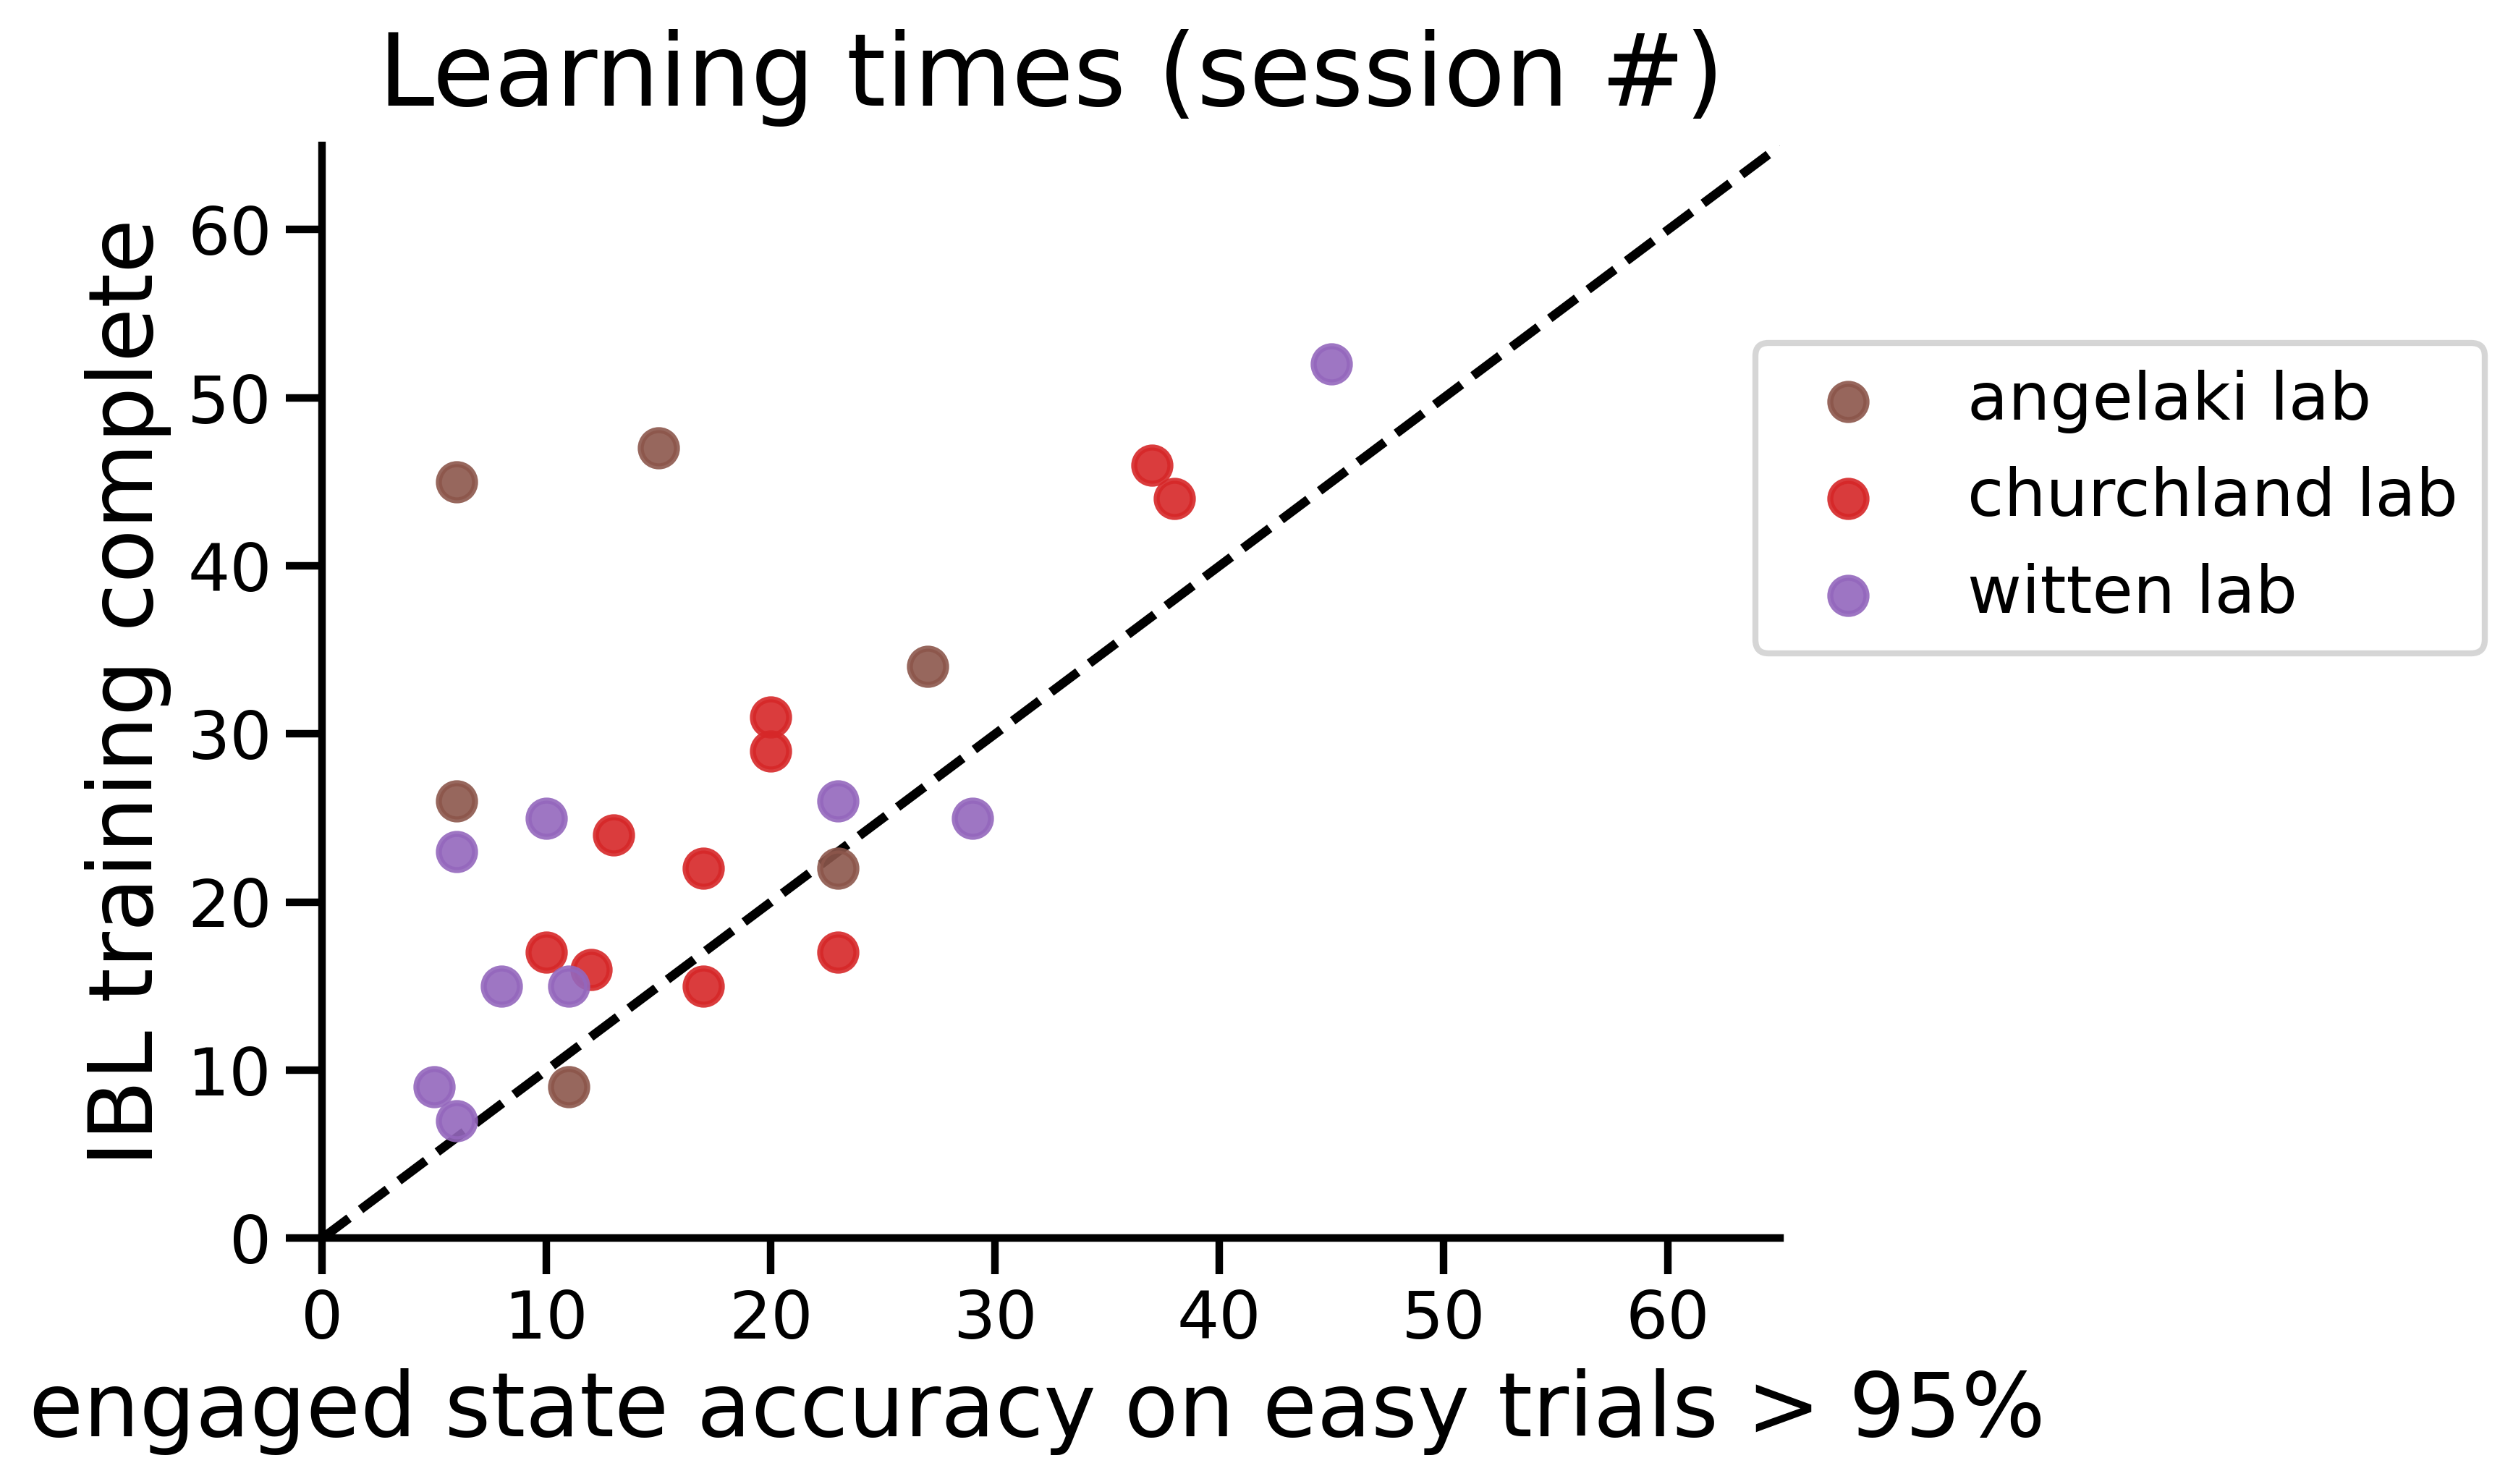

In [65]:
# Learning times as defined by IBL vs dynamic GLM-HMM
treshold = 95
def learning_time(accuracySession, treshold=0.95): # decided for accuracy on easy trials  
    sessions = accuracySession.shape[0]
    time = -1
    for t in range(1,sessions):
        if (np.mean(accuracySession[t-1:t+1]) >= treshold):
            time = t
            break 
    return time

colors_labs = ['tab:brown','tab:red','tab:purple']
labChosen =  ['angelaki lab','churchland lab','witten lab']

fig, axes = plt.subplots(1, figsize = (6.5, 5), dpi=400) 

learningTimes = np.zeros((len(subjectsAll)))
firstBlockSession = np.zeros((len(subjectsAll)))
for idx in range(0, len(subjectsAll)):
    learningTimes[idx] = learning_time(arrStateSeparateCorrect[:,0,idx, 1], treshold=treshold)

    subject = subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
    _, _, _, firstBlockSession[idx] = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)

    if idx in [0,15,30]:
        axes.scatter(learningTimes[idx], firstBlockSession[idx], c=colors_labs[int(lab_identity[idx])], alpha=0.9, label=labChosen[int(lab_identity[idx])])
    else:
        axes.scatter(learningTimes[idx], firstBlockSession[idx], c=colors_labs[int(lab_identity[idx])], alpha=0.9)

axes.set_ylabel('IBL training complete', size=22)
axes.set_xlabel('engaged state accuracy on easy trials > ' + str(treshold) +'% ', size=22)
axes.set_xlim(0,65)
axes.set_ylim(0,65)
axes.spines[['right', 'top']].set_visible(False)
axes.set_title('Learning times (session #)', size=25, pad=10)
axes.plot([0, 65], [0, 65], ls="--", c='black', zorder=0)
axes.legend(bbox_to_anchor=(0.96, 0.85))
# plt.savefig(f'../figures/LearningTimes_Scatter_allAnimals', bbox_inches='tight', dpi=400)

# Supplemental Figure 3B

In [ ]:
# Plotting weights and transition matrix averaged across all animals - first 50 sessions
maxSess = 55
reorderFeatures = [1,0,2,3] 
myFeatures = ['stimulus','bias','previous choice','previous correct side']

arrW = np.ma.empty((maxSess, K, D, 2, len(subjectsAll)))
arrW.mask = True

fig, axes = plt.subplots(4, 1,figsize=(12.7,21), sharex=True, dpi=400)
fig.tight_layout(pad=4)
yLim=[[-0.5,6.2],[-2.7,2.7],[-2.7,2.7],[-2.7,2.7]]
# yLim=[[-0.5,4.2],[-2.7,2.7],[-2.7,2.7],[-2.7,2.7]] # pTanh = 5

avgP = []
avgW = []
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)

    avgW.append(allW_best_dynamic[idx][sessInd[:-1]]) 
    # avgP.append(allP[idx][sessInd])
    stop = min(avgW[idx].shape[0], maxSess)
    arrW[:stop, :K, :D, :2, idx] = avgW[idx][:stop]
    # plotting_weights_per_feature((avgW[idx][:stop,:,reorderFeatures[:2]]), [x for x in range (0, stop)], axes, yLim=yLim, colors=colorsStates, labels=['stimulus','bias','previous choice','previous correct answer'], linewidth=4, linestyle='-', alpha=1, legend=False, sortedStateInd=None) # 0.08 alpha
plotting_weights_per_feature((arrW.mean(axis=4)[:,:,reorderFeatures]), [x for x in range (0, maxSess)], axes, yLim=yLim, colors=colorsStates, labels=['stimulus','bias','previous choice','previous correct answer'], linewidth=4, linestyle='-', alpha=1, legend=True, sortedStateInd=None)
    
# # stimulus and bias weights
# for d in range(0,D-2):
#     if (d!=0):
#         axes[d].get_legend().remove()
#         axes[0].legend(loc = 'upper left')
#     axes[d].set_ylim(yLim[d])
#     axes[d].set_ylabel(f'weights', size=22)
#     axes[d].set_title(f'{myFeatures[d]} weights', size=24)
#     axes[d].spines[['right', 'top']].set_visible(False)
# fig.suptitle('Average inferred dynamic weights', size=25)
# axes[-1].set_xlabel('session', size=22)

# # other weights
# for d in range(D-2,4):
#     if (d!=0):
#         axes[d].get_legend().remove()
#         axes[0].legend(loc = 'upper left')
    
#     axes[d].set_ylabel(f'weights')
#     axes[d].set_title(f'{myFeatures[d]} weights', size=22)
#     axes[d].spines[['right', 'top']].set_visible(False)

# plt.savefig(f'../figures/weights_sigma=1_allAnimals.png', bbox_inches='tight', dpi=400)

# Supplemental Figure 2C

In [ ]:
# NEW SAVING OF FILES AND MORE ANIMALS:
testLlAll = np.zeros((K_max, len(subjectsAll), len(alphaList)+1))
bestTestLl = np.zeros((K_max, len(subjectsAll)))
testAccuracyAll = np.zeros((K_max, len(subjectsAll), len(alphaList)+1))
bestTestAccuracy = np.zeros((K_max, len(subjectsAll)))

bestSigmaInd = 7
for idx in range(0, len(subjectsAll)):
    subject = subjectsAll[idx]
    testLl = []
    testAccuracy = []
    avgTestLl = []
    old_avgTestLl = []
    avgTestAccuracy = []

    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
    N = x.shape[0]
    presentTrain, presentTest = split_data(N, sessInd, folds=splitFolds, blocks=10, random_state=1)
    sess = len(sessInd) - 1

    for K in [1,2,3]:
        llFolds = np.empty((splitFolds), dtype=object)
        llFolds2 = np.empty((splitFolds), dtype=object)
        for fold in range(splitFolds):
            if K == 1:
                bestSigmaInd = 7
                data = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
            else:
                data = np.load(f'../data_IBL/{subject}/{subject}_dynamicGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
            llFolds[fold] = data['testLl']
            llFolds2[fold] = data['testAccuracy']
        avgTestLl.append(np.mean(llFolds, axis=0))
        avgTestAccuracy.append(np.mean(llFolds2, axis=0))

        # llFolds = np.empty((splitFolds), dtype=object)
        # for fold in range(splitFolds):
        #     data = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh=0.01_L2penaltyW=1_signedStimulus={signedStimulus}.npz')
        #     llFolds[fold] = data['testLl']
        # old_avgTestLl.append(np.mean(llFolds, axis=0))

        # old_data = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh=0.01_L2penaltyW=1_signedStimulus={signedStimulus}.npz')
        # old_testLl = old_data['testLl']
    
        # old_avgTestLl.append(np.mean(old_testLl,axis=0))

    # avgTestLl = [x - avgTestLl[0][0] for x in avgTestLl] # normalizing to GLM-HMM sigma=0 K=1
    # old_avgTestLl = [x - old_avgTestLl[0][0] for x in old_avgTestLl]
    for K in [1,2,3]:
        if K == 1:
            testLlAll[K-1][idx] = avgTestLl[K-1][bestSigmaInd]
        else:
            testLlAll[K-1][idx] = avgTestLl[K-1]
            testAccuracyAll[K-1][idx] = avgTestAccuracy[K-1]
        # old_testLlAll[K-1][idx] = old_avgTestLl[K-1]

    # bestSigmaInd = 7 # Choosing best sigma index across animals
    # for K in [2,3]:
    #     bestTestLl[K-1][idx] = avgTestLl[K-1][bestSigmaInd] - avgTestLl[0][bestSigmaInd] # delta
    #     bestTestAccuracy[K-1][idx] = avgTestAccuracy[K-1][bestSigmaInd] - avgTestAccuracy[0][bestSigmaInd]
            
# Plotting one plot with all animals and their mean
fig, axes = plt.subplots(1, figsize = (12,4.5), dpi=400)
# fig, axes = plt.subplots(1, figsize = (12,5.5), dpi=400)
fig.tight_layout()
# axes.set_title('averaged across all animals')
for K in range(3,0,-1):
    # for idx in range(0, len(subjectsAll)):
    #     subject = subjectsAll[idx]
    #     plot_testLl_CV_sigma(testLlAll[K-1][idx], sigmaList=sigmaList, label=None, color=colormap[K-1], axes=axes, alpha=0.06)
    plot_testLl_CV_alpha(np.mean(testLlAll[K-1], axis=0) * avg_session_length, alphaList=alphaList, label=f'K={K}', color=colormap[K-1], axes=axes, alpha=1)

    # plot_testLl_CV_sigma(np.mean(old_testLlAll[K-1], axis=0) * avg_session_length, sigmaList=sigmaList, label=f'K={K}', color='black', axes=axes, alpha=1, linestyle='--')
axes.set_ylabel("    test log-like (session)", size=22)
axes.set_xlabel('')
axes.spines[['right', 'top']].set_visible(False)
axes.set_ylim(-375,-365)
axes.set_title('Average model performance as a function of # states and     ', size=24)
# plt.savefig(f'../figures/TestLl_vs_states_sigma_all-animals.png', bbox_inches='tight', dpi=400)
    